In [34]:
import polars as pl
import pandas as pd
import numpy as np
import pyreadr 
import requests
import pickle

import time
from datetime import datetime

# Config

In [35]:
class config:
    base_path = './Aim2_Data_March2025/'
    med_col_focus = 'ATC_codes'
 

# Web scrapper for medications

In [179]:
import requests
from bs4 import BeautifulSoup

In [180]:
def get_ndc_active_ingrident_webscrapper(ndc_code):
    r = requests.get('https://fda.report/NDC/{}'.format(ndc_code))
    soup = BeautifulSoup(r.content, 'html.parser')
    s = soup.find('table', class_='table')
    rows = s.find_all('tr')

    if r.status_code!=200:
        raise Exception('Status code is not 200')
    # Loop through the rows and extract the 'Substance Name'
    substance_name = None
    for row in rows:
       header, value = row.find_all('td')
       if header.text.strip() == 'Substance Name':
           substance_name = value.text.strip()
           break

    if substance_name is None:
        print(ndc_code)
        return ndc_code

    return substance_name
    

In [181]:
get_ndc_active_ingrident_webscrapper('0006-0952')

'LOSARTAN POTASSIUM'

# Loading data

In [36]:
## loading the csv files
demo_df = pl.read_csv(config.base_path + "vdw_demos.csv")
diag_df = pl.read_csv(config.base_path + "vdw_dx.csv")
enco_df = pl.read_csv(config.base_path + "vdw_encounters.csv")
labs_df = pl.read_csv(config.base_path + "vdw_labs.csv",infer_schema_length=0)
meds_df = pl.read_csv(config.base_path + "vdw_meds_v2.csv", schema_overrides={'ndc': pl.String})
procedure_df = pl.read_csv(config.base_path + "vdw_px.csv")


## required patient ids
# req_pid_info_df = pl.read_csv(config.base_path + "cohort_info.csv")

In [37]:
cli_notes_df_part1 = pl.read_csv(config.base_path + "all_notes_March25_hfhs.csv",encoding='latin1',infer_schema_length=0)
cli_notes_df_part2 = pl.read_csv(config.base_path + "all_notes_hfhs.csv",encoding='latin1',infer_schema_length=0)
cli_notes_df = pl.concat([cli_notes_df_part1, cli_notes_df_part2])

# EDA 

## EDA for demographics dataset

In [38]:
### EDA for demographics ###
demo_df.head()

patient,NHL,RACE1,RACE2,RACE3,RACE4,RACE5,HISPANIC,NEEDS_INTERPRETER,SEX_ADMIN,SEX_AT_BIRTH,GENDER_IDENTITY,birth_year
i64,str,str,str,str,str,str,str,str,str,str,str,i64
333,"""DLBCL""","""WH""","""UN""","""UN""","""UN""","""UN""","""U""","""U""","""M""","""U""","""UN""",1943
364,"""DLBCL""","""WH""","""UN""","""UN""","""UN""","""UN""","""N""","""N""","""M""","""U""","""UN""",1943
43,"""FL""","""WH""","""UN""","""UN""","""UN""","""UN""","""N""","""N""","""M""","""U""","""UN""",1925
45,"""FL""","""WH""","""UN""","""UN""","""UN""","""UN""","""N""","""N""","""M""","""M""","""MM""",1926
72,"""FL""","""WH""","""UN""","""UN""","""UN""","""UN""","""U""","""U""","""M""","""U""","""UN""",1924


In [39]:
demo_df.group_by('SEX_ADMIN').count()

C:\Users\rachac\AppData\Local\Temp\ipykernel_424\3906552638.py:1: DeprecationWarning: `GroupBy.count` was renamed; use `GroupBy.len` instead
  demo_df.group_by('SEX_ADMIN').count()


SEX_ADMIN,count
str,u32
"""F""",69
"""M""",82


In [40]:
req_demo_cols = ['RACE1','RACE2','RACE3','RACE4','RACE5','HISPANIC','GENDER_IDENTITY']

In [41]:
### EDA for diagnoses
diag_df.describe()

statistic,patient,NHL,example,ENCTYPE,ENC_ID,ADATE,DX,DX_CODETYPE,ORIGDX,SOURCE_DATA_DX,PRINCIPAL_DX,PRIMARY_DX,ATIME
str,f64,str,str,str,f64,str,str,f64,str,str,str,str,str
"""count""",34265.0,"""34265""","""34265""","""34265""",34265.0,"""34265""","""34265""",34265.0,"""34265""","""34265""","""34265""","""34265""","""19195"""
"""null_count""",0.0,"""0""","""0""","""0""",0.0,"""0""","""0""",0.0,"""0""","""0""","""0""","""0""","""15070"""
"""mean""",207.657697,null,null,null,7.2058e12,null,null,9.514402,null,null,null,null,null
"""std""",115.970551,null,null,null,9.6288e12,null,null,0.4998,null,null,null,null,null
"""min""",1.0,"""DLBCL""","""NEG""","""AV""",1.3093327e7,"""1/1/2009""","""008.45""",9.0,"""008.45""","""E""","""N""","""P""","""00:13:00"""
"""25%""",109.0,null,null,null,1.0463e10,null,null,9.0,null,null,null,null,null
"""50%""",212.0,null,null,null,1.0660e10,null,null,10.0,null,null,null,null,null
"""75%""",312.0,null,null,null,2.0070e13,null,null,10.0,null,null,null,null,null
"""max""",389.0,"""FL""","""POS""","""VC""",2.0130e13,"""9/9/2022""","""Z99.81""",10.0,"""Z99.81""","""E""","""X""","""X""","""23:59:00"""


In [42]:
for col in req_demo_cols:
    print('Column name:', col)
    print(np.unique(demo_df[col].to_numpy(), return_counts = True))

Column name: RACE1
(array(['AS', 'BA', 'OT', 'UN', 'WH'], dtype=object), array([  2,  28,   1,   3, 117], dtype=int64))
Column name: RACE2
(array(['OT', 'UN'], dtype=object), array([  2, 149], dtype=int64))
Column name: RACE3
(array(['UN'], dtype=object), array([151], dtype=int64))
Column name: RACE4
(array(['UN'], dtype=object), array([151], dtype=int64))
Column name: RACE5
(array(['UN'], dtype=object), array([151], dtype=int64))
Column name: HISPANIC
(array(['N', 'U', 'Y'], dtype=object), array([128,  22,   1], dtype=int64))
Column name: GENDER_IDENTITY
(array(['FF', 'MM', 'UN'], dtype=object), array([ 14,  16, 121], dtype=int64))


# EDA for interval dates for each sample

In [43]:
file_name  = config.base_path + "selected_cohort_send_with_flt.csv"

In [44]:
pid_date_df = pl.read_csv(file_name)

In [45]:
print("Number of data points in the dataset: ",len(pid_date_df))

Number of data points in the dataset:  963


In [46]:
print("Number of unique patients in the dataset: ",len(np.unique(pid_date_df['patient'].to_list())))

Number of unique patients in the dataset:  151


In [47]:
pid_date_df.head()

patient,Record_ID,NHL,dx_date,startdate1,enddate1,recur,Abstractor_recur_dt,date_1st_finish
i64,i64,str,str,str,str,str,str,str
1,137,"""DLBCL""","""5/23/2002""","""4/19/2006""","""10/16/2006""",null,null,"""6/27/2002"""
1,137,"""DLBCL""","""5/23/2002""","""4/11/2007""","""10/8/2007""",null,null,"""6/27/2002"""
1,137,"""DLBCL""","""5/23/2002""","""3/19/2008""","""9/15/2008""",null,null,"""6/27/2002"""
1,137,"""DLBCL""","""5/23/2002""","""3/18/2009""","""9/14/2009""",null,null,"""6/27/2002"""
1,137,"""DLBCL""","""5/23/2002""","""9/2/2010""","""3/1/2011""","""Y""","""N""","""6/27/2002"""


In [48]:
pid_date_df  = pid_date_df.with_columns(pl.col("dx_date").str.to_datetime("%m/%d/%Y",strict=False).alias('dx_date'),
                                       pl.col("startdate1").str.to_datetime("%m/%d/%Y",strict=False).alias('startdate1'))

In [49]:
print('Distribution of recur column: ', pid_date_df.group_by('recur').count())

Distribution of recur column:  shape: (2, 2)
┌───────┬───────┐
│ recur ┆ count │
│ ---   ┆ ---   │
│ str   ┆ u32   │
╞═══════╪═══════╡
│ Y     ┆ 65    │
│ null  ┆ 898   │
└───────┴───────┘


C:\Users\rachac\AppData\Local\Temp\ipykernel_424\2172506073.py:1: DeprecationWarning: `GroupBy.count` was renamed; use `GroupBy.len` instead
  print('Distribution of recur column: ', pid_date_df.group_by('recur').count())


In [50]:
pid_date_df = pid_date_df.with_columns(pl.col('recur').fill_null('N'))

In [51]:
pid_date_df.null_count()

patient,Record_ID,NHL,dx_date,startdate1,enddate1,recur,Abstractor_recur_dt,date_1st_finish
u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,898,32


In [52]:
pid_date_df.head()

patient,Record_ID,NHL,dx_date,startdate1,enddate1,recur,Abstractor_recur_dt,date_1st_finish
i64,i64,str,datetime[μs],datetime[μs],str,str,str,str
1,137,"""DLBCL""",2002-05-23 00:00:00,2006-04-19 00:00:00,"""10/16/2006""","""N""",null,"""6/27/2002"""
1,137,"""DLBCL""",2002-05-23 00:00:00,2007-04-11 00:00:00,"""10/8/2007""","""N""",null,"""6/27/2002"""
1,137,"""DLBCL""",2002-05-23 00:00:00,2008-03-19 00:00:00,"""9/15/2008""","""N""",null,"""6/27/2002"""
1,137,"""DLBCL""",2002-05-23 00:00:00,2009-03-18 00:00:00,"""9/14/2009""","""N""",null,"""6/27/2002"""
1,137,"""DLBCL""",2002-05-23 00:00:00,2010-09-02 00:00:00,"""3/1/2011""","""Y""","""N""","""6/27/2002"""


In [53]:
len(pid_date_df.filter(pl.col("startdate1") < datetime(2012, 7, 11)))

348

In [54]:
np.unique(pid_date_df.filter(pl.col("startdate1") >= datetime(2012, 7, 11))['recur'].to_list(), return_counts =True)

(array(['N', 'Y'], dtype='<U1'), array([587,  28], dtype=int64))

In [55]:
print("Number of data points before 11/07/2012 :",len(pid_date_df.filter(pl.col('startdate1')< datetime(2012, 7, 11))))
print("Number of data points before 11/07/2012 which have label Yes :",len(pid_date_df.filter((pl.col('startdate1')< datetime(2012, 7, 11))
                                                                                           & (pl.col('recur') == 'Y')))  )

Number of data points before 11/07/2012 : 348
Number of data points before 11/07/2012 which have label Yes : 37


In [56]:
# pid_date_df = pid_date_df.filter(pl.col('patient').is_in(req_pid_info_df['patient'].to_list())) ## filtering pids based

In [57]:
print('Number of unique patient records after new cohort pids: ',len(np.unique(pid_date_df['patient'].to_list())))

Number of unique patient records after new cohort pids:  151


# EDA for Medications

### 1. standardized ndc codes by converting them to generic names (some of the NDC codes are not available in NDC data because they got delisted by FDA)

In [58]:
class NDC_ATC_DICT:
    def __init__(self):
        self.ndc_atc_dict = {}

    def get_a

SyntaxError: expected '(' (3607187371.py, line 5)

In [59]:
### function for converting  ndc code to ATC code

def convert_ndc_to_atc(ndc: str, level = 4):
    time.sleep(0.15)
    assert 1 <= level <= 4, "level keyword should be between 1 and 4"
    assert len(ndc) == 11, "Number of digits in ndc code should be equal to 11"
    
    ### get rxcui
    response = requests.get("https://rxnav.nlm.nih.gov/REST/ndcstatus.json?ndc=" + ndc)
    # print(response.json())

    if response.status_code != 200:

        print(f'Error in ndc code: {ndc} at retriving rxcui')
        return None

    response_ndc = response.json()
    try:
        rxcui = [data['activeRxcui']  for data in response_ndc['ndcStatus']['ndcHistory'] if data['activeRxcui']][-1]
    except:
        print('failed at getting rxcui',ndc)
        return None
    response_rx = requests.get(f'https://rxnav.nlm.nih.gov/REST/rxclass/class/byRxcui.json?rxcui={rxcui}&relaSource=ATC')

    atc_codes = []
    
    if response_rx.status_code != 200:

        print(f'Error in ndc code: {ndc} at retriving atc codes')
        return None

    try:
        for data in  response_rx.json()['rxclassDrugInfoList']['rxclassDrugInfo']:
            atc_codes.append(data['rxclassMinConceptItem']['classId'])
    except:
            try:
                if response_rx.json() == {}:
                    
                    response_rx = requests.get(f'https://rxnav.nlm.nih.gov/REST/rxclass/class/byRxcui.json?caller=RxNav&rxcui={rxcui}&relaSource=ATCPROD')
                    # Collecting all ATC class IDs for rxcui '876193'
                    atc_codes = [item["rxclassMinConceptItem"]["classId"]
                         for item in response_rx.json()["rxclassDrugInfoList"]["rxclassDrugInfo"]
                         if item["minConcept"]["rxcui"] == rxcui]
                
            except:
                print('Failed at getting atc codes:',ndc)
                return None
        
    atc_codes = np.unique([atc_code[:level+1] for atc_code in atc_codes]).tolist()
    
    return atc_codes
        

convert_ndc_to_atc('00574041205',level=2) 

['A06']

In [64]:
# Initialize an empty dictionary to store the NDC to ATC mappings
ndc_to_atc_dict = {}

# Function to convert NDC to ATC or retrieve from the dictionary
def map_ndc_to_atc_with_dict(ndc):
    if ndc in ndc_to_atc_dict:
        return ndc_to_atc_dict[ndc]
    else:
        atc_codes = convert_ndc_to_atc(ndc, level=2)
        ndc_to_atc_dict[ndc] = atc_codes
        return atc_codes

# Apply the mapping to the DataFrame and store the result in the dictionary
meds_df = meds_df.with_columns(
    pl.col('ndc').map_elements(map_ndc_to_atc_with_dict).alias('ATC_codes')
)

C:\Users\rachac\AppData\Local\Temp\ipykernel_424\3744174675.py:14: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  meds_df = meds_df.with_columns(


failed at getting rxcui 49452391704
failed at getting rxcui 52268052101
failed at getting rxcui 70461012003
failed at getting rxcui 32909073503
failed at getting rxcui 58177083537
failed at getting rxcui 08290328203
failed at getting rxcui 08290320109
failed at getting rxcui 08290320122
failed at getting rxcui 59930156001
failed at getting rxcui 08290320119
failed at getting rxcui 08496310101
failed at getting rxcui 08627001601
failed at getting rxcui 08627005303
failed at getting rxcui 08290309623
failed at getting rxcui 60258016201
failed at getting rxcui 00169185250
failed at getting rxcui 08290309571
failed at getting rxcui 58177009604
failed at getting rxcui 49281038815
failed at getting rxcui 90166083152
failed at getting rxcui 08627009111
failed at getting rxcui 49281012065
failed at getting rxcui 08290309570
failed at getting rxcui 11917004813
failed at getting rxcui 00597001314
failed at getting rxcui 33332001001
failed at getting rxcui 59528445601
failed at getting rxcui 0052

In [61]:
with open('ndc_atc_mapping.pkl','rb') as f:
    ndc_atc_mapping = pickle.load(f)

In [65]:
# Initialize an empty dictionary to store the mapping
ndc_atc_mapping = {}

# Iterate over the DataFrame rows
for row in meds_df.rows():
    key, value = row[4],row[-1]
    # Add to mapping only if the key is not already present
    if key not in ndc_atc_mapping:
        ndc_atc_mapping[key] = value

# Resulting dictionary
# with open('ndc_atc_mapping.pkl','wb') as f:
#     pickle.dump(ndc_atc_mapping,f)

In [66]:
meds_df = meds_df.explode('ATC_codes')

In [67]:
if config.med_col_focus == 'ATC_codes':
    meds_df = meds_df.drop_nulls(subset = ['ATC_codes'])

In [68]:
meds_df.head()

patient,NHL,example,rxdate,ndc,rxsup,rxamt,BRAND,STRENGTH,GENERIC,ATC_codes
i64,str,str,str,str,i64,f64,str,str,str,str
2,"""FL""","""NEG""","""12/27/2007""","""00378045105""",30,60.0,"""NAPROXEN""","""500 mg""","""NAPROXEN""","""G02"""
2,"""FL""","""NEG""","""12/27/2007""","""00378045105""",30,60.0,"""NAPROXEN""","""500 mg""","""NAPROXEN""","""M01"""
2,"""FL""","""NEG""","""12/27/2007""","""00378045105""",30,60.0,"""NAPROXEN""","""500 mg""","""NAPROXEN""","""M02"""
2,"""FL""","""NEG""","""12/27/2007""","""00781175001""",20,60.0,"""METHOCARBAMOL""","""750 mg""","""METHOCARBAMOL""","""M03"""
2,"""FL""","""NEG""","""12/27/2007""","""63304056210""",20,60.0,"""ACETAMINOPHEN-CODEINE""","""300 mg-30 mg""","""ACETAMINOPHEN WITH CODEINE PHO…","""N02"""


In [69]:
'dexamethasone'.upper() in meds_df['BRAND'].to_list()

True

In [70]:
import requests

def get_drug_class(generic_name):
    # First, get RxCUI (RxNorm Concept Unique Identifier) for the drug
    resp = requests.get(f"https://rxnav.nlm.nih.gov/REST/rxcui.json?name={generic_name}")
    data = resp.json()
    rxcui = data.get('idGroup', {}).get('rxnormId', [None])[0]
    if rxcui is None:
        return f"No RxCUI found for {generic_name}"

    # Then, get drug class info using the rxcui
    resp2 = requests.get(f"https://rxnav.nlm.nih.gov/REST/rxcui/{rxcui}/property.json?propName=VA+CLASS")
    print(resp2)
    class_data = resp2.json()
    prop_concept = class_data.get('propConceptGroup', {}).get('propConcept', [])
    if not prop_concept:
        return f"No drug class found for {generic_name}"

    # There can be multiple classes
    return [item['propValue'] for item in prop_concept]

# Example usage:
# print(get_drug_class("alprazolam"))

In [71]:
print("Number of rows in medications dataset: ",len(meds_df))

Number of rows in medications dataset:  14850


In [72]:
print("Number of unique patient records in medications dataset: ",len(np.unique(meds_df['patient'].to_list())))

Number of unique patient records in medications dataset:  126


In [73]:
print("Number of unique ndc codes in medications dataset: ",len(np.unique(meds_df['ndc'].to_list())))

Number of unique ndc codes in medications dataset:  2063


In [74]:
print("Number of unique generic names in medications dataset: ",len(np.unique(meds_df['GENERIC'].to_list())))

Number of unique generic names in medications dataset:  389


In [75]:
meds_df.null_count()

patient,NHL,example,rxdate,ndc,rxsup,rxamt,BRAND,STRENGTH,GENERIC,ATC_codes
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0


In [76]:
# import requests

# def ndc_data_from_ndc(code):
#     # API endpoint
#     url = 'https://api.fda.gov/drug/ndc.json?search=product_ndc:"'+code+'"&limit=1'
    
#     # Make a GET request
#     response = requests.get(url)
    
#     # Check if the request was successful
#     if response.status_code == 200:
#         data = response.json()
#         return data
#     raise Exception("Response code is not 200")

# test = ndc_data_from_ndc('0006-0952')
# print(test)

In [77]:
# import json
# with open('drug-ndc-0001-of-0001.json', 'r') as file:
#     all_ndc_data_json = json.load(file)

In [78]:
# for med in meds_df['ndc'].to_list():
#     if med.count('0')==1 and med[-2]=="0":
#         print(med)

In [79]:
# x = '00065000203'
# print(f"{x[1:4]}-{x[4:8]}-{x[8:10]}")

In [80]:
def ndc_product_code_to_act_ing(ndc_product_code):
    result =  next(( d['generic_name'].lower() for d in all_ndc_data_json['results'] if d.get('product_ndc') == ndc_product_code), 
                   ndc_product_code)
    return result

In [81]:
meds_df = meds_df.with_columns(pl.col('ndc').cast(pl.Utf8).alias('ndc'))

In [82]:
meds_df.filter(pl.col('ATC_codes') == 'L01')

patient,NHL,example,rxdate,ndc,rxsup,rxamt,BRAND,STRENGTH,GENERIC,ATC_codes
i64,str,str,str,str,i64,f64,str,str,str,str
28,"""DLBCL""","""POS""","""11/11/2015""","""00378326694""",2,8.0,"""ETOPOSIDE""","""50 mg""","""ETOPOSIDE""","""L01"""
151,"""FL""","""NEG""","""10/30/2022""","""51672411806""",30,40.0,"""FLUOROURACIL""","""5 %""","""FLUOROURACIL""","""L01"""
169,"""DLBCL""","""POS""","""9/5/2008""","""54482005301""",7,14.0,"""MATULANE""","""50 mg""","""PROCARBAZINE HCL""","""L01"""
169,"""DLBCL""","""POS""","""10/14/2008""","""54482005301""",7,14.0,"""MATULANE""","""50 mg""","""PROCARBAZINE HCL""","""L01"""
169,"""DLBCL""","""POS""","""11/10/2008""","""54482005301""",7,14.0,"""MATULANE""","""50 mg""","""PROCARBAZINE HCL""","""L01"""
…,…,…,…,…,…,…,…,…,…,…
346,"""DLBCL""","""POS""","""1/7/2003""","""00025152531""",30,30.0,"""CELEBREX""","""200 mg""","""CELECOXIB""","""L01"""
346,"""DLBCL""","""POS""","""2/10/2003""","""00025152531""",30,30.0,"""CELEBREX""","""200 mg""","""CELECOXIB""","""L01"""
346,"""DLBCL""","""POS""","""3/16/2003""","""00025152531""",30,30.0,"""CELEBREX""","""200 mg""","""CELECOXIB""","""L01"""


In [83]:
# meds_df = meds_df.with_columns(pl.col("ndc").map_elements(ndc_code_to_product_ndc,return_dtype=pl.Utf8).alias('ndc_product_code'))
# meds_df.filter(pl.col('ndc_product_code').is_null())

In [84]:
x = []
for ndc  in meds_df['ndc'].to_list():
    x.append(len(ndc))

print(np.unique(x))

[11]


In [85]:
meds_df.head(10)

patient,NHL,example,rxdate,ndc,rxsup,rxamt,BRAND,STRENGTH,GENERIC,ATC_codes
i64,str,str,str,str,i64,f64,str,str,str,str
2,"""FL""","""NEG""","""12/27/2007""","""00378045105""",30,60.0,"""NAPROXEN""","""500 mg""","""NAPROXEN""","""G02"""
2,"""FL""","""NEG""","""12/27/2007""","""00378045105""",30,60.0,"""NAPROXEN""","""500 mg""","""NAPROXEN""","""M01"""
2,"""FL""","""NEG""","""12/27/2007""","""00378045105""",30,60.0,"""NAPROXEN""","""500 mg""","""NAPROXEN""","""M02"""
2,"""FL""","""NEG""","""12/27/2007""","""00781175001""",20,60.0,"""METHOCARBAMOL""","""750 mg""","""METHOCARBAMOL""","""M03"""
2,"""FL""","""NEG""","""12/27/2007""","""63304056210""",20,60.0,"""ACETAMINOPHEN-CODEINE""","""300 mg-30 mg""","""ACETAMINOPHEN WITH CODEINE PHO…","""N02"""
2,"""FL""","""NEG""","""12/27/2007""","""63304056210""",20,60.0,"""ACETAMINOPHEN-CODEINE""","""300 mg-30 mg""","""ACETAMINOPHEN WITH CODEINE PHO…","""R05"""
2,"""FL""","""NEG""","""5/12/2008""","""00093014901""",30,60.0,"""NAPROXEN""","""500 mg""","""NAPROXEN""","""G02"""
2,"""FL""","""NEG""","""5/12/2008""","""00093014901""",30,60.0,"""NAPROXEN""","""500 mg""","""NAPROXEN""","""M01"""
2,"""FL""","""NEG""","""5/12/2008""","""00093014901""",30,60.0,"""NAPROXEN""","""500 mg""","""NAPROXEN""","""M02"""


In [86]:
len(np.unique(meds_df['GENERIC'].to_list()))

389

In [87]:
meds_df = meds_df.with_columns(pl.lit(1).alias('Usage'))
meds_df.head(10)

patient,NHL,example,rxdate,ndc,rxsup,rxamt,BRAND,STRENGTH,GENERIC,ATC_codes,Usage
i64,str,str,str,str,i64,f64,str,str,str,str,i32
2,"""FL""","""NEG""","""12/27/2007""","""00378045105""",30,60.0,"""NAPROXEN""","""500 mg""","""NAPROXEN""","""G02""",1
2,"""FL""","""NEG""","""12/27/2007""","""00378045105""",30,60.0,"""NAPROXEN""","""500 mg""","""NAPROXEN""","""M01""",1
2,"""FL""","""NEG""","""12/27/2007""","""00378045105""",30,60.0,"""NAPROXEN""","""500 mg""","""NAPROXEN""","""M02""",1
2,"""FL""","""NEG""","""12/27/2007""","""00781175001""",20,60.0,"""METHOCARBAMOL""","""750 mg""","""METHOCARBAMOL""","""M03""",1
2,"""FL""","""NEG""","""12/27/2007""","""63304056210""",20,60.0,"""ACETAMINOPHEN-CODEINE""","""300 mg-30 mg""","""ACETAMINOPHEN WITH CODEINE PHO…","""N02""",1
2,"""FL""","""NEG""","""12/27/2007""","""63304056210""",20,60.0,"""ACETAMINOPHEN-CODEINE""","""300 mg-30 mg""","""ACETAMINOPHEN WITH CODEINE PHO…","""R05""",1
2,"""FL""","""NEG""","""5/12/2008""","""00093014901""",30,60.0,"""NAPROXEN""","""500 mg""","""NAPROXEN""","""G02""",1
2,"""FL""","""NEG""","""5/12/2008""","""00093014901""",30,60.0,"""NAPROXEN""","""500 mg""","""NAPROXEN""","""M01""",1
2,"""FL""","""NEG""","""5/12/2008""","""00093014901""",30,60.0,"""NAPROXEN""","""500 mg""","""NAPROXEN""","""M02""",1


In [88]:
len(np.unique(meds_df['ndc'].to_list(
)))

2063

In [89]:
meds_df.head(10)['GENERIC'].to_list()

['NAPROXEN',
 'NAPROXEN',
 'NAPROXEN',
 'METHOCARBAMOL',
 'ACETAMINOPHEN WITH CODEINE PHOSPHATE',
 'ACETAMINOPHEN WITH CODEINE PHOSPHATE',
 'NAPROXEN',
 'NAPROXEN',
 'NAPROXEN',
 'HYDROCODONE BITARTRATE/ACETAMINOPHEN']

In [90]:
len(np.unique(meds_df['GENERIC'].to_list()))

389

In [91]:
medications_generic_name = np.unique(np.unique(meds_df[config.med_col_focus].to_numpy()))
medications_generic_name[:5]

array(['A01', 'A02', 'A03', 'A04', 'A05'], dtype=object)

In [92]:
meds_df.filter(pl.col('ndc').str.len_chars() <8)

patient,NHL,example,rxdate,ndc,rxsup,rxamt,BRAND,STRENGTH,GENERIC,ATC_codes,Usage
i64,str,str,str,str,i64,f64,str,str,str,str,i32


In [93]:


#### Pivoting medications data based on usage
meds_usage_pivot_df = meds_df.pivot(on =config.med_col_focus,index = ['patient','rxdate'],values = 'Usage', aggregate_function = 'max', sort_columns = True)
meds_usage_pivot_df = meds_usage_pivot_df.with_columns(
    pl.col("rxdate").str.strptime(pl.Date, "%m/%d/%Y").alias("rxdate"),
    pl.col("patient").cast(pl.Int32).alias("patient")
)
meds_usage_pivot_df = meds_usage_pivot_df.fill_null(0)
meds_usage_pivot_df

patient,rxdate,A01,A02,A03,A04,A05,A06,A07,A10,A11,A12,B01,B02,B03,B05,C01,C02,C03,C04,C05,C07,C08,C09,C10,D01,D02,D03,D04,D05,D06,D07,D08,D09,D10,D11,G01,…,G04,H02,H03,J01,J02,J04,J05,J07,L01,L02,L03,L04,M01,M02,M03,M04,M05,N01,N02,N03,N04,N05,N06,N07,P01,P02,P03,R01,R02,R03,R05,R06,S01,S02,S03,V03,V04
i32,date,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,…,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32
2,2007-12-27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2008-05-12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2008-06-18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,2008-06-20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2008-06-25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
380,2018-05-11,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
380,2018-05-23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
380,2018-07-06,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# EDA for Diagnoses

### 1. Standardized ICD codes from 9 to 10.
### 2. Invalid ICD-9 codes which cannot be converted to ICD-10 are  appended with "ICD-9" prefix

In [94]:
diag_df.head()

patient,NHL,example,ENCTYPE,ENC_ID,ADATE,DX,DX_CODETYPE,ORIGDX,SOURCE_DATA_DX,PRINCIPAL_DX,PRIMARY_DX,ATIME
i64,str,str,str,i64,str,str,i64,str,str,str,str,str
333,"""DLBCL""","""NEG""","""AV""",20120000047251,"""7/17/2012""","""200.88""",9,"""200.88""","""E""","""X""","""P""",null
333,"""DLBCL""","""NEG""","""AV""",20120000047251,"""7/17/2012""","""202.88""",9,"""202.88""","""E""","""X""","""P""",null
333,"""DLBCL""","""NEG""","""AV""",20120000047252,"""7/30/2012""","""200.78""",9,"""200.78""","""E""","""X""","""P""",null
333,"""DLBCL""","""NEG""","""AV""",20120000047252,"""7/30/2012""","""202.08""",9,"""202.08""","""E""","""X""","""P""",null
333,"""DLBCL""","""NEG""","""AV""",20120000047252,"""7/30/2012""","""204.10""",9,"""204.10""","""E""","""X""","""P""",null


In [95]:
print("Number of unique patients in diagnoses data: ", len(np.unique(diag_df['patient'].to_list())))

Number of unique patients in diagnoses data:  150


In [96]:
print("Number of unique ICD code types: ",np.unique(diag_df['DX_CODETYPE'].to_list(), return_counts =True))
print("Number of unique ICD codes: ", len(np.unique(diag_df['ORIGDX'].to_list())))

Number of unique ICD code types:  (array([ 9, 10]), array([16639, 17626], dtype=int64))
Number of unique ICD codes:  2974


In [97]:
# Phecodes
icd10_phe = pl.read_csv('./icd_code_to_phecode/Phecode_map_v1_2_icd10cm_beta.csv')
icd9_phe_v1 =  pl.read_csv('./icd_code_to_phecode/phecode_map_v1_2_icd9.csv',infer_schema_length=100000)
icd9_phe_v2 = pyreadr.read_r("./icd_code_to_phecode/phemap (1).rda")['phemap'].drop_duplicates(subset=['icd9'])

In [98]:
### dicts for mapping ###
icd10_phe_dict = dict(zip(icd10_phe['ICD10CM'].to_list(), icd10_phe['PHECODE'].to_list()))
icd9_phe_dict_v1 = dict(zip(icd9_phe_v1['ICD9'].to_list(), icd9_phe_v1['PheCode'].to_list()))
icd9_phe_dict_v2 = dict(zip(icd9_phe_v2['icd9'].to_list(), icd9_phe_v2['phecode'].to_list()))

In [99]:
diag_df.filter(pl.col('ORIGDX') == 'Z96.642')

patient,NHL,example,ENCTYPE,ENC_ID,ADATE,DX,DX_CODETYPE,ORIGDX,SOURCE_DATA_DX,PRINCIPAL_DX,PRIMARY_DX,ATIME
i64,str,str,str,i64,str,str,i64,str,str,str,str,str
45,"""FL""","""NEG""","""AV""",10604945732,"""3/8/2018""","""Z96.642""",10,"""Z96.642""","""E""","""X""","""S""","""15:30:00"""
46,"""FL""","""NEG""","""AV""",10700176963,"""2/8/2022""","""Z96.642""",10,"""Z96.642""","""E""","""X""","""P""","""06:10:00"""
46,"""FL""","""NEG""","""AV""",10711888650,"""3/18/2022""","""Z96.642""",10,"""Z96.642""","""E""","""X""","""P""","""08:30:00"""
46,"""FL""","""NEG""","""AV""",10715281027,"""6/17/2022""","""Z96.642""",10,"""Z96.642""","""E""","""X""","""P""","""14:00:00"""
46,"""FL""","""NEG""","""IP""",10719799013,"""6/27/2022""","""Z96.642""",10,"""Z96.642""","""E""","""N""","""X""","""13:20:00"""
…,…,…,…,…,…,…,…,…,…,…,…,…
46,"""FL""","""NEG""","""IP""",10719799411,"""7/15/2022""","""Z96.642""",10,"""Z96.642""","""E""","""P""","""X""","""14:36:00"""
46,"""FL""","""NEG""","""IP""",10719799412,"""7/18/2022""","""Z96.642""",10,"""Z96.642""","""E""","""P""","""X""","""11:52:00"""
46,"""FL""","""NEG""","""IP""",10720657601,"""7/25/2022""","""Z96.642""",10,"""Z96.642""","""E""","""P""","""X""","""15:12:00"""


In [100]:
phe_codes_map_list = []
icd_code_not_found10 = []
icd_code_not_found9 = []
for row in diag_df.rows(named=True):
    if row['DX_CODETYPE'] == 9:
        try:
            phe_codes_map_list.append('phe'+str(icd9_phe_dict_v2[row['ORIGDX']]))
        except:
            try:
                phe_codes_map_list.append('phe'+str(icd9_phe_dict_v1[row['ORIGDX']]))
            except:
                
                try:
                    phe_codes_map_list.append('phe'+str(icd10_phe_dict[standarize_elements_icd10([row['ORIGDX']],9)]))
                except:
                    print(row['ORIGDX'])
                    phe_codes_map_list.append('ICD_9_'+row['ORIGDX'].split('.')[0])
    if row['DX_CODETYPE'] == 10:
        try:
            phe_codes_map_list.append('phe'+str(icd10_phe_dict[row['ORIGDX']]))
        except:
            phe_codes_map_list.append('ICD_10_'+row['ORIGDX'].split('.')[0])

V70.8
V70.8
V81.4
564.00
V45.89
V70.0
V72.81
V72.81
V70.0
564.00
IMO0001
564.00
564.00
V70.0
V70.0
V15.9
V72.83
V15.9
V72.83
V15.9
V72.83
V15.9
V72.83
V15.9
V72.83
V72.85
V15.9
V72.83
V15.9
V58.69
V72.83
V15.9
V72.83
V72.83
V58.69
V72.83
V15.9
V72.83
V72.83
V15.9
V72.83
V15.9
V72.83
V15.9
V72.83
V15.9
V72.83
V15.9
V72.83
V15.9
V72.83
V72.83
V72.83
V72.83
V15.9
V72.83
V15.9
V72.83
V70.0
V76.12
V76.12
V58.78
V15.9
V72.83
V45.69
V77.91
V80.1
V70.0
564.00
V58.31
V58.81
V76.51
V76.51
V69.4
V70.0
V70.0
V70.0
V82.81
V82.81
V76.51
V76.51
V76.51
E849.0
E878.2
E849.7
E878.8
V64.41
V70.0
V70.0
V70.0
V65.42
784.0
784.0
784.0
V59.02
V59.02
V59.02
V42.9
V42.9
V42.9
V42.9
V42.9
E888.9
V58.2
V59.02
V59.02
V59.02
V58.2
V58.2
E980.4
E980.4
E980.4
E980.4
E980.4
V59.02
V42.9
V70.0
E980.4
V58.81
V67.59
V76.2
V72.31
V76.12
V76.12
V45.89
V45.89
E849.7
V76.12
V72.83
V67.00
V67.00
IMO0001
IMO0001
IMO0001
IMO0001
V49.89
V70.0
V76.51
V72.84
V72.81
V72.81
V70.0
V70.0
V70.0
V72.83
V67.00
V70.0
V70.0
IMO0001
IMO000

In [101]:
len(np.unique(([id for id in  phe_codes_map_list if id.startswith('ICD')])))

129

In [102]:
len(np.unique(phe_codes_map_list))

1243

In [103]:
diag_df.null_count()

patient,NHL,example,ENCTYPE,ENC_ID,ADATE,DX,DX_CODETYPE,ORIGDX,SOURCE_DATA_DX,PRINCIPAL_DX,PRIMARY_DX,ATIME
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,15070


In [104]:
diag_df.group_by('DX_CODETYPE').count()

C:\Users\rachac\AppData\Local\Temp\ipykernel_424\2431368851.py:1: DeprecationWarning: `GroupBy.count` was renamed; use `GroupBy.len` instead
  diag_df.group_by('DX_CODETYPE').count()


DX_CODETYPE,count
i64,u32
10,17626
9,16639


In [105]:
diag_df.filter(pl.col('DX_CODETYPE')== 10)

patient,NHL,example,ENCTYPE,ENC_ID,ADATE,DX,DX_CODETYPE,ORIGDX,SOURCE_DATA_DX,PRINCIPAL_DX,PRIMARY_DX,ATIME
i64,str,str,str,i64,str,str,i64,str,str,str,str,str
45,"""FL""","""NEG""","""AV""",10194770840,"""3/16/2016""","""C82.90""",10,"""C82.90""","""E""","""X""","""P""","""08:30:00"""
45,"""FL""","""NEG""","""AV""",10194770840,"""3/16/2016""","""C91.10""",10,"""C91.10""","""E""","""X""","""S""","""08:30:00"""
45,"""FL""","""NEG""","""AV""",10205360866,"""6/22/2016""","""C82.90""",10,"""C82.90""","""E""","""X""","""P""","""09:00:00"""
45,"""FL""","""NEG""","""AV""",10207827154,"""3/28/2016""","""L43.9""",10,"""L43.9""","""E""","""X""","""P""","""13:00:00"""
45,"""FL""","""NEG""","""AV""",10457601302,"""4/3/2017""","""I10""",10,"""I10""","""E""","""X""","""S""","""14:40:00"""
…,…,…,…,…,…,…,…,…,…,…,…,…
335,"""DLBCL""","""POS""","""VC""",10608039504,"""4/25/2018""","""E11.9""",10,"""E11.9""","""E""","""X""","""S""",null
335,"""DLBCL""","""POS""","""VC""",10609656205,"""5/21/2018""","""C83.38""",10,"""C83.38""","""E""","""X""","""S""",null
335,"""DLBCL""","""POS""","""VC""",10610547586,"""6/4/2018""","""C83.38""",10,"""C83.38""","""E""","""X""","""P""",null


In [143]:
len(np.unique(diag_df['ORIGDX'].to_list()))

2974

In [144]:
print(mapper.map("599.7".replace('.',''), source='icd9', target='icd10'))

NameError: name 'mapper' is not defined

In [107]:
from icdmappings import Mapper
mapper = Mapper()

def standarize_elements_icd10(dx_type, dx):
    if dx_type == 10:
        return dx
    elif dx_type == 9:
        icd10_code = mapper.map(dx.replace('.',''), source='icd9', target='icd10')
        if icd10_code is None:
            
            return "ICD_9_" + dx
        #return icd10_code
        else:
            return icd10_code[:3]+'.'+icd10_code[3:]
    
def get_ICD_10_first_3_chars(stand_ICD):
    if stand_ICD.startswith("ICD_9"):
        return stand_ICD
    else:
        try:
            return stand_ICD[:5]
        except:
            print(stand_ICD)
            return stand_ICD[:3]
    

In [108]:
diag_df = diag_df.with_columns(pl.struct(['DX_CODETYPE','ORIGDX']) \
       .map_elements(lambda x: standarize_elements_icd10(x['DX_CODETYPE'], x['ORIGDX']), return_dtype =pl.Utf8).alias('Standardized_ICD10'))

diag_df = diag_df.with_columns(pl.col(['Standardized_ICD10']) \
       .map_elements(lambda x: get_ICD_10_first_3_chars(x) , return_dtype =pl.Utf8).alias('ICD10_modeling_col'))

In [109]:
print("Number of  icd 9 codes that cant be converted to ICd 10: ",len(diag_df.filter(pl.col('Standardized_ICD10').str.starts_with('ICD'))))

Number of  icd 9 codes that cant be converted to ICd 10:  166


In [110]:
diag_df.head()

patient,NHL,example,ENCTYPE,ENC_ID,ADATE,DX,DX_CODETYPE,ORIGDX,SOURCE_DATA_DX,PRINCIPAL_DX,PRIMARY_DX,ATIME,Standardized_ICD10,ICD10_modeling_col
i64,str,str,str,i64,str,str,i64,str,str,str,str,str,str,str
333,"""DLBCL""","""NEG""","""AV""",20120000047251,"""7/17/2012""","""200.88""",9,"""200.88""","""E""","""X""","""P""",null,"""C83.88""","""C83.8"""
333,"""DLBCL""","""NEG""","""AV""",20120000047251,"""7/17/2012""","""202.88""",9,"""202.88""","""E""","""X""","""P""",null,"""C85.88""","""C85.8"""
333,"""DLBCL""","""NEG""","""AV""",20120000047252,"""7/30/2012""","""200.78""",9,"""200.78""","""E""","""X""","""P""",null,"""C83.38""","""C83.3"""
333,"""DLBCL""","""NEG""","""AV""",20120000047252,"""7/30/2012""","""202.08""",9,"""202.08""","""E""","""X""","""P""",null,"""C82.98""","""C82.9"""
333,"""DLBCL""","""NEG""","""AV""",20120000047252,"""7/30/2012""","""204.10""",9,"""204.10""","""E""","""X""","""P""",null,"""C91.10""","""C91.1"""


In [111]:
count = phe_codes_map_list.count(None)
print(count)  # Output: 3

0


In [112]:
'1010.0' in phe_codes_map_list

False

In [113]:
diag_df = diag_df.with_columns(pl.Series("phecode_from_icd",phe_codes_map_list))

In [114]:
diag_df.null_count()

patient,NHL,example,ENCTYPE,ENC_ID,ADATE,DX,DX_CODETYPE,ORIGDX,SOURCE_DATA_DX,PRINCIPAL_DX,PRIMARY_DX,ATIME,Standardized_ICD10,ICD10_modeling_col,phecode_from_icd
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,0,15070,0,0,0


In [115]:
# diag_df.filter(pl.col('Standardized_ICD10').is_null())

In [116]:
diag_df.shape

(34265, 16)

In [117]:
diag_df = diag_df.with_columns(pl.lit(1).alias('DX_diagnosed'))
diag_df.head()

patient,NHL,example,ENCTYPE,ENC_ID,ADATE,DX,DX_CODETYPE,ORIGDX,SOURCE_DATA_DX,PRINCIPAL_DX,PRIMARY_DX,ATIME,Standardized_ICD10,ICD10_modeling_col,phecode_from_icd,DX_diagnosed
i64,str,str,str,i64,str,str,i64,str,str,str,str,str,str,str,str,i32
333,"""DLBCL""","""NEG""","""AV""",20120000047251,"""7/17/2012""","""200.88""",9,"""200.88""","""E""","""X""","""P""",null,"""C83.88""","""C83.8""","""phe202.22""",1
333,"""DLBCL""","""NEG""","""AV""",20120000047251,"""7/17/2012""","""202.88""",9,"""202.88""","""E""","""X""","""P""",null,"""C85.88""","""C85.8""","""phe202.2""",1
333,"""DLBCL""","""NEG""","""AV""",20120000047252,"""7/30/2012""","""200.78""",9,"""200.78""","""E""","""X""","""P""",null,"""C83.38""","""C83.3""","""phe202.24""",1
333,"""DLBCL""","""NEG""","""AV""",20120000047252,"""7/30/2012""","""202.08""",9,"""202.08""","""E""","""X""","""P""",null,"""C82.98""","""C82.9""","""phe202.21""",1
333,"""DLBCL""","""NEG""","""AV""",20120000047252,"""7/30/2012""","""204.10""",9,"""204.10""","""E""","""X""","""P""",null,"""C91.10""","""C91.1""","""phe204.12""",1


In [118]:
unique_modeling_icds = np.unique(diag_df['phecode_from_icd'].to_list())
len(unique_modeling_icds)

1243

In [169]:
unique_modeling_icds[:-5]

array(['ICD_10_B37', 'ICD_10_C83', 'ICD_10_C85', ..., 'phe979',
       'phe979.0', 'phe980.0'], dtype='<U14')

In [119]:
diag_df_pivot  = diag_df.pivot(on = 'phecode_from_icd', index = ['patient','ADATE'], values = 'DX_diagnosed', aggregate_function ='first')
diag_df_pivot = diag_df_pivot.with_columns(
    pl.col("ADATE").str.strptime(pl.Date, "%m/%d/%Y").alias("ADATE")
).drop(['phe1010.0'])
diag_df_pivot.head()

patient,ADATE,phe202.22,phe202.2,phe202.24,phe202.21,phe204.12,phe204.11,phe240,ICD_9_V70,phe480,phe285,phe401.1,phe427.61,phe495,ICD_9_V81,phe117.4,phe276.12,phe276.42,phe284.1,phe287.31,phe480.2,phe480.3,phe960.2,phe318.0,phe197,phe112,phe415.11,ICD_9_564,phe743.21,phe509.8,phe600,phe244.4,ICD_9_V45,phe300.12,phe296.2,phe523,…,ICD_10_Z97,ICD_10_Z91,phe840.2,phe727.6,phe574.3,phe735.2,phe282.9,phe415.21,phe170.2,phe724.1,phe557.0,phe250.41,ICD_10_G93,ICD_10_D68,phe536.3,ICD_10_Z98,phe618.1,phe601.8,phe711.1,phe587.0,phe604.0,phe290.2,phe315.1,ICD_10_Z89,ICD_10_Z74,phe710.11,phe324.0,phe367.2,phe747.1,phe931.0,phe728.71,phe426.31,phe473.1,ICD_10_D59,phe859.0,phe947.0,phe204.3
i64,date,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,…,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32
333,2012-07-17,1,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
333,2012-07-30,null,null,1,1,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
333,2012-08-07,null,null,null,null,null,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
333,2012-08-14,null,null,null,null,null,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
333,2012-08-21,null,1,null,null,null,null,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


In [120]:
'1010.0' in diag_df_pivot.columns

False

# EDA for LabResults

### 1. LabLOINCS missing for half the data (24174 out of 51140)
### 2. We can use LOCAL_CD instead which has lower count of missing (1760)
### 3. In result, we have non-numerical values
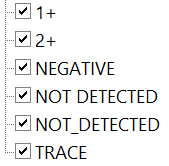

#### Need to check if the lab results associated with these can be categorical or the result values possible

In [121]:
labs_df.head()

patient,NHL,example,TEST_TYPE,STAT,LOINC,PT_LOC,RESULT_LOC,SPECIMEN_SOURCE,LOCAL_CD,BATTERY_CD,PX,PX_codetype,ORDER_DT,LAB_DT,LAB_TM,RESULT_DT,RESULT_TM,RESULT_C,MODIFIER,RESULT_UNIT,NORMAL_LOW_C,MODIFIER_LOW,NORMAL_HIGH_C,MODIFIER_HIGH,ABN_IND,RESULT_UNIT_RAW
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""333""","""DLBCL""","""NEG""","""ALBUMIN""","""U""",null,"""U""","""L""","""NS""","""ALB""","""LIVR""",null,null,"""8/21/2012""","""8/21/2012""","""15:39:00""","""8/21/2012""","""22:09:00""","""4""","""EQ""","""G/DL""","""3.2""","""EQ""","""4.6""","""EQ""","""UK""","""G/DL"""
"""333""","""DLBCL""","""NEG""","""ALBUMIN""","""U""",null,"""U""","""L""","""NS""","""ALB""","""LIVR""",null,null,"""8/28/2012""","""8/28/2012""","""14:52:00""","""8/28/2012""","""22:47:00""","""3.8""","""EQ""","""G/DL""","""3.2""","""EQ""","""4.6""","""EQ""","""UK""","""G/DL"""
"""333""","""DLBCL""","""NEG""","""ALBUMIN""","""U""",null,"""U""","""L""","""NS""","""ALB""","""BCPRO""",null,null,"""7/17/2012""","""7/17/2012""","""13:50:00""","""7/17/2012""","""22:14:00""","""2.8""","""EQ""","""G/DL""","""3.2""","""EQ""","""4.6""","""EQ""","""AB""","""G/DL"""
"""333""","""DLBCL""","""NEG""","""ALBUMIN""","""U""",null,"""U""","""L""","""NS""","""ALB""","""BCPRO""",null,null,"""7/30/2012""","""7/30/2012""","""13:40:00""","""7/30/2012""","""18:45:00""","""3.2""","""EQ""","""G/DL""","""3.2""","""EQ""","""4.6""","""EQ""","""UK""","""G/DL"""
"""333""","""DLBCL""","""NEG""","""ALBUMIN""","""U""",null,"""U""","""L""","""NS""","""ALB""","""LIVR""",null,null,"""9/5/2012""","""9/5/2012""","""14:51:00""","""9/5/2012""","""22:21:00""","""3.6""","""EQ""","""G/DL""","""3.2""","""EQ""","""4.6""","""EQ""","""UK""","""G/DL"""


In [122]:
print("Number of unique patient records in labs_df: ",len(np.unique(labs_df['patient'].to_list())))

Number of unique patient records in labs_df:  148


In [123]:
### Finding Local cd or loincs where result is categorical
cat_result_local_cd = np.unique(labs_df.filter(pl.col('RESULT_C').is_in(['1+','2+','3+','NEGATIVE', 'POSITIVE','Positive','NOT DETECTED',
                                                                         'NOT DETECTED','NOT_DETECTED',
                                                                         'TRACE','POSITIVE','DETECTED',
                                                                        'LARGE', 'UNABLE TO CALCULATE']))['LOCAL_CD'].to_list()).tolist()

In [124]:
len(np.unique(labs_df.select(pl.col("LOINC").drop_nulls())['LOINC'].to_list()))

87

In [125]:
print("Number of records in lab results: ",len(labs_df))

Number of records in lab results:  173244


In [126]:
print("Number of records in LOINC code is missing: ",len(labs_df.filter(pl.col('LOINC').is_null())))

Number of records in LOINC code is missing:  114294


In [127]:
print("Number of records in Local_CD code is missing: ",len(labs_df.filter(pl.col('LOCAL_CD').is_null())))

Number of records in Local_CD code is missing:  7062


In [128]:
print("Number of records in Local_CD code is missing: ",len(np.unique(labs_df.filter(~pl.col('LOCAL_CD').is_null())['LOCAL_CD'].to_list())))

Number of records in Local_CD code is missing:  333


In [129]:
for local_cd in cat_result_local_cd:
    print("The local cd {} has following result values:".format(local_cd))
    uniq_results = np.unique(labs_df.filter(pl.col('LOCAL_CD') == local_cd)['RESULT_C'].to_list())
    print(uniq_results)
    print()
    print('*'*20)
    

The local cd 1390 has following result values:
['10.1' '101.6' '1085.7' '11.5' '1102.2' '12.5' '13.4' '13.6' '14.0'
 '14.6' '141.9' '178.7' '20.9' '2091.7' '21.2' '21.7' '233.9' '24.2'
 '24.6' '2957.4' '30.2' '323.5' '34.6' '4.1' '4.6' '492.7' '5.4' '5.6'
 '51.5' '53.5' '6.2' '6.5' '620.2' '7.0' '7.3' '7.7' '7.8' '752.5' '781.1'
 '8.6' '82.7' '83.6' '854.1' '860.5' '9.2' '9.3' 'UNABLE TO CALCULATE']

********************
The local cd 1526626 has following result values:
['NEGATIVE' 'NOT DETECTED' 'NOT_DETECTED']

********************
The local cd 1551412 has following result values:
['100' '30' '300' '500' 'NEGATIVE' 'Negative' 'TRACE']

********************
The local cd 1553978 has following result values:
['NEGATIVE']

********************
The local cd 1555062 has following result values:
['NEGATIVE' 'NOT DETECTED' 'POSITIVE']

********************
The local cd 1740126 has following result values:
['NEGATIVE']

********************
The local cd 1810497 has following result values:
['

In [130]:
 np.unique(labs_df.filter(pl.col('LOCAL_CD') == '1810500')['RESULT_C'].to_list())

array(['NOT DETECTED'], dtype='<U12')

In [131]:
cat_result_local_cd.remove('1390')

In [132]:
cat_result_local_cd

['1526626',
 '1551412',
 '1553978',
 '1555062',
 '1740126',
 '1810497',
 '1810500',
 '2100626',
 '2105',
 '21051',
 '2205',
 '2206',
 '2271',
 '2358',
 '2359',
 '2360',
 '2361',
 '2362',
 '2866',
 '3236',
 '3237',
 '3238',
 '367',
 '3893',
 '4094',
 '4187',
 '714',
 'CULT',
 'OCCBLD',
 'UMETH',
 'UOPI',
 'UPRO',
 'UPROT',
 'UPRPX']

In [133]:
labs_df.head()

patient,NHL,example,TEST_TYPE,STAT,LOINC,PT_LOC,RESULT_LOC,SPECIMEN_SOURCE,LOCAL_CD,BATTERY_CD,PX,PX_codetype,ORDER_DT,LAB_DT,LAB_TM,RESULT_DT,RESULT_TM,RESULT_C,MODIFIER,RESULT_UNIT,NORMAL_LOW_C,MODIFIER_LOW,NORMAL_HIGH_C,MODIFIER_HIGH,ABN_IND,RESULT_UNIT_RAW
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""333""","""DLBCL""","""NEG""","""ALBUMIN""","""U""",null,"""U""","""L""","""NS""","""ALB""","""LIVR""",null,null,"""8/21/2012""","""8/21/2012""","""15:39:00""","""8/21/2012""","""22:09:00""","""4""","""EQ""","""G/DL""","""3.2""","""EQ""","""4.6""","""EQ""","""UK""","""G/DL"""
"""333""","""DLBCL""","""NEG""","""ALBUMIN""","""U""",null,"""U""","""L""","""NS""","""ALB""","""LIVR""",null,null,"""8/28/2012""","""8/28/2012""","""14:52:00""","""8/28/2012""","""22:47:00""","""3.8""","""EQ""","""G/DL""","""3.2""","""EQ""","""4.6""","""EQ""","""UK""","""G/DL"""
"""333""","""DLBCL""","""NEG""","""ALBUMIN""","""U""",null,"""U""","""L""","""NS""","""ALB""","""BCPRO""",null,null,"""7/17/2012""","""7/17/2012""","""13:50:00""","""7/17/2012""","""22:14:00""","""2.8""","""EQ""","""G/DL""","""3.2""","""EQ""","""4.6""","""EQ""","""AB""","""G/DL"""
"""333""","""DLBCL""","""NEG""","""ALBUMIN""","""U""",null,"""U""","""L""","""NS""","""ALB""","""BCPRO""",null,null,"""7/30/2012""","""7/30/2012""","""13:40:00""","""7/30/2012""","""18:45:00""","""3.2""","""EQ""","""G/DL""","""3.2""","""EQ""","""4.6""","""EQ""","""UK""","""G/DL"""
"""333""","""DLBCL""","""NEG""","""ALBUMIN""","""U""",null,"""U""","""L""","""NS""","""ALB""","""LIVR""",null,null,"""9/5/2012""","""9/5/2012""","""14:51:00""","""9/5/2012""","""22:21:00""","""3.6""","""EQ""","""G/DL""","""3.2""","""EQ""","""4.6""","""EQ""","""UK""","""G/DL"""


In [134]:
### removing unable to calculate data
labs_df = labs_df.filter(pl.col('RESULT_C') != 'UNABLE TO CALCULATE')

In [135]:
labs_df.null_count()

patient,NHL,example,TEST_TYPE,STAT,LOINC,PT_LOC,RESULT_LOC,SPECIMEN_SOURCE,LOCAL_CD,BATTERY_CD,PX,PX_codetype,ORDER_DT,LAB_DT,LAB_TM,RESULT_DT,RESULT_TM,RESULT_C,MODIFIER,RESULT_UNIT,NORMAL_LOW_C,MODIFIER_LOW,NORMAL_HIGH_C,MODIFIER_HIGH,ABN_IND,RESULT_UNIT_RAW
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,114292,0,0,482,7062,11656,173242,173242,1528,0,0,1528,1528,0,0,4935,47138,47138,39015,39015,0,4935


In [136]:
### Filtering out null local cd
labs_df = labs_df.filter(~pl.col('LOCAL_CD').is_null())

In [137]:
len(labs_df)

166180

In [138]:
# labs_df.filter(pl.col('LOCAL_CD')=='UPROT')['RESULT_UNIT'].to_list()

In [139]:
labs_df.group_by('LOCAL_CD').agg(
        pl.col('RESULT_UNIT').n_unique().alias("count_unique_units")
    ).filter(pl.col('count_unique_units')!=1)

LOCAL_CD,count_unique_units
str,u32
"""1551412""",2
"""1510640""",2
"""UPROT""",2
"""2271""",2


In [140]:
labs_df.filter(pl.col('LOCAL_CD') =='UPROT')

patient,NHL,example,TEST_TYPE,STAT,LOINC,PT_LOC,RESULT_LOC,SPECIMEN_SOURCE,LOCAL_CD,BATTERY_CD,PX,PX_codetype,ORDER_DT,LAB_DT,LAB_TM,RESULT_DT,RESULT_TM,RESULT_C,MODIFIER,RESULT_UNIT,NORMAL_LOW_C,MODIFIER_LOW,NORMAL_HIGH_C,MODIFIER_HIGH,ABN_IND,RESULT_UNIT_RAW
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str
"""333""","""DLBCL""","""NEG""","""U_PROT_DIP""","""U""",null,"""U""","""L""","""NS""","""UPROT""","""UA""",null,null,"""10/16/2012""","""10/16/2012""","""13:24:00""","""10/16/2012""","""13:48:00""","""100""","""EQ""","""MG/DL""",null,null,null,null,"""AB""","""MG/DL"""
"""333""","""DLBCL""","""NEG""","""U_PROT_DIP""","""U""",null,"""U""","""L""","""URINE""","""UPROT""","""UA""",null,null,"""10/16/2012""","""10/16/2012""","""13:24:00""","""10/16/2012""","""13:48:00""","""2+""","""TX""",null,""" .""","""GT""",""" .""","""LT""","""AB""",null
"""72""","""FL""","""NEG""","""U_PROT_DIP""","""U""",null,"""U""","""L""","""URINE""","""UPROT""","""UA""",null,null,"""5/1/2006""","""5/1/2006""","""15:32:00""","""5/1/2006""","""15:52:24""","""NEGATIVE""","""TX""",null,null,null,null,null,"""UK""",null
"""72""","""FL""","""NEG""","""U_PROT_DIP""","""U""",null,"""U""","""L""","""URINE""","""UPROT""","""UA""",null,null,"""4/28/2006""","""4/28/2006""","""11:31:00""","""4/28/2006""","""11:53:47""","""TRACE""","""TX""",null,null,null,null,null,"""UK""",null
"""72""","""FL""","""NEG""","""U_PROT_DIP""","""U""",null,"""U""","""L""","""URINE""","""UPROT""","""UA""",null,null,"""2/14/2006""","""2/14/2006""","""15:50:00""","""2/14/2006""","""22:12:11""","""NEGATIVE""","""TX""",null,null,null,null,null,"""UK""",null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""242""","""DLBCL""","""NEG""","""U_PROT_DIP""","""U""",null,"""U""","""L""","""NS""","""UPROT""","""UA""",null,null,"""8/29/2014""","""8/29/2014""","""08:57:00""","""8/29/2014""","""09:42:00""","""30""","""EQ""","""MG/DL""",null,null,null,null,"""AB""","""MG/DL"""
"""242""","""DLBCL""","""NEG""","""U_PROT_DIP""","""U""",null,"""U""","""L""","""URINE""","""UPROT""","""UA""",null,null,"""8/29/2014""","""8/29/2014""","""08:57:00""","""8/29/2014""","""09:42:00""","""1+""","""TX""",null,""" .""","""GT""",""" .""","""LT""","""AB""",null
"""85""","""DLBCL""","""POS""","""U_PROT_DIP""","""U""",null,"""U""","""L""","""URINE""","""UPROT""","""UA""",null,null,"""9/9/2010""","""9/9/2010""","""05:55:00""","""9/9/2010""","""07:39:09""","""NEGATIVE""","""TX""",null,null,null,null,null,"""UK""",null


In [141]:
### DROPPING ROWS WITH LOCAL_CD as NULL ###
labs_df = labs_df.drop_nulls(['LOCAL_CD'])

In [142]:
labs_df.null_count()

patient,NHL,example,TEST_TYPE,STAT,LOINC,PT_LOC,RESULT_LOC,SPECIMEN_SOURCE,LOCAL_CD,BATTERY_CD,PX,PX_codetype,ORDER_DT,LAB_DT,LAB_TM,RESULT_DT,RESULT_TM,RESULT_C,MODIFIER,RESULT_UNIT,NORMAL_LOW_C,MODIFIER_LOW,NORMAL_HIGH_C,MODIFIER_HIGH,ABN_IND,RESULT_UNIT_RAW
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,107230,0,0,474,0,11597,166180,166180,1528,0,0,1528,1528,0,0,4935,40079,40079,32385,32385,0,4935


In [143]:
labs_df.filter(pl.col('patient') == '249')

patient,NHL,example,TEST_TYPE,STAT,LOINC,PT_LOC,RESULT_LOC,SPECIMEN_SOURCE,LOCAL_CD,BATTERY_CD,PX,PX_codetype,ORDER_DT,LAB_DT,LAB_TM,RESULT_DT,RESULT_TM,RESULT_C,MODIFIER,RESULT_UNIT,NORMAL_LOW_C,MODIFIER_LOW,NORMAL_HIGH_C,MODIFIER_HIGH,ABN_IND,RESULT_UNIT_RAW
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str


In [144]:
#### Pivoting labs_df
labs_df_pivot = labs_df.pivot(on = 'LOCAL_CD',index = ['patient','LAB_DT'], values = 'RESULT_C', aggregate_function = 'first')
labs_df_pivot = labs_df_pivot.with_columns(
    pl.col("LAB_DT").str.strptime(pl.Date, "%m/%d/%Y").alias("LAB_DT"),
    pl.col("patient").cast(pl.Int32).alias("patient")
)
labs_df_pivot = labs_df_pivot.drop(cat_result_local_cd)

# Get current column names
columns = labs_df_pivot.columns

# Prepare new column names with "Lab_" prefix except for the first column
new_columns = columns[:2] + [f"Lab_{col}" for col in columns[2:]]

# Rename the columns
labs_df_pivot = labs_df_pivot.rename({old: new for old, new in zip(columns, new_columns)})

print(labs_df_pivot)


shape: (7_375, 301)
┌─────────┬────────────┬─────────┬──────────┬───┬──────────┬──────────┬─────────┬─────────────┐
│ patient ┆ LAB_DT     ┆ Lab_ALB ┆ Lab_ALKP ┆ … ┆ Lab_1490 ┆ Lab_BHCG ┆ Lab_917 ┆ Lab_1776946 │
│ ---     ┆ ---        ┆ ---     ┆ ---      ┆   ┆ ---      ┆ ---      ┆ ---     ┆ ---         │
│ i32     ┆ date       ┆ str     ┆ str      ┆   ┆ str      ┆ str      ┆ str     ┆ str         │
╞═════════╪════════════╪═════════╪══════════╪═══╪══════════╪══════════╪═════════╪═════════════╡
│ 333     ┆ 2012-08-21 ┆ 4       ┆ 104      ┆ … ┆ null     ┆ null     ┆ null    ┆ null        │
│ 333     ┆ 2012-08-28 ┆ 3.8     ┆ 127      ┆ … ┆ null     ┆ null     ┆ null    ┆ null        │
│ 333     ┆ 2012-07-17 ┆ 2.8     ┆ 248      ┆ … ┆ null     ┆ null     ┆ null    ┆ null        │
│ 333     ┆ 2012-07-30 ┆ 3.2     ┆ 148      ┆ … ┆ null     ┆ null     ┆ null    ┆ null        │
│ 333     ┆ 2012-09-05 ┆ 3.6     ┆ 168      ┆ … ┆ null     ┆ null     ┆ null    ┆ null        │
│ …       ┆ …       

In [145]:
### columns to convert to float
columns_to_float = list(set(list(labs_df_pivot.columns)) - set(cat_result_local_cd) - set(['patient','LAB_DT']))
len(columns_to_float)

299

In [146]:
labs_df_pivot = labs_df_pivot.with_columns([pl.col(col).cast(pl.Float32) for col in columns_to_float])

In [147]:
labs_df_pivot.head()

patient,LAB_DT,Lab_ALB,Lab_ALKP,Lab_SGPT,Lab_SGOT,Lab_AGR,Lab_ABASO,Lab_1812405,Lab_BPCT,Lab_BILD,Lab_TBIL,Lab_BNPR,Lab_BUN,Lab_CA,Lab_CL,Lab_CO2,Lab_CRET,Lab_CRPR,Lab_AEOS,Lab_EPCT,Lab_ESR,Lab_GFRAA,Lab_GFRNAA,Lab_GLUC,Lab_HCO3,Lab_HCT,Lab_HGB,Lab_INR,Lab_K,Lab_LDH,Lab_ALYMP,Lab_LPCT,Lab_MG,Lab_AMONO,Lab_MPCT,Lab_ABAN,…,Lab_HCTW,Lab_RBCFOL,Lab_693,Lab_ALK,Lab_MABASO,Lab_BASO,Lab_MBASO,Lab_BILIT,Lab_CKMB4,Lab_MAEOS,Lab_EOS,Lab_MEOS,Lab_MALYMP,Lab_LYMP,Lab_MLYMP,Lab_MAMONO,Lab_MONO,Lab_MMONO,Lab_MABAND,Lab_MBAND,Lab_ANEUT,Lab_MANEUT,Lab_NEUT,Lab_MNEUT,Lab_PT1,Lab_TROP,Lab_WBK,Lab_2981,Lab_366,Lab_1483,Lab_1511127,Lab_1485,Lab_1491,Lab_1490,Lab_BHCG,Lab_917,Lab_1776946
i32,date,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
333,2012-08-21,4.0,104.0,51.0,44.0,null,0.0,null,1.0,0.2,0.6,null,null,null,null,null,null,null,0.1,2.0,null,null,null,null,null,36.700001,12.5,null,null,514.0,0.3,8.0,null,0.3,8.0,0.1,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
333,2012-08-28,3.8,127.0,44.0,49.0,null,0.0,0.0,null,0.2,0.5,null,null,null,null,null,null,null,0.0,0.0,null,null,null,null,null,36.299999,12.5,null,null,546.0,0.2,7.0,null,0.4,16.0,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
333,2012-07-17,2.8,248.0,96.0,42.0,1.0,0.0,null,null,null,0.4,null,25.0,9.1,103.0,24.0,1.06,null,0.0,0.0,null,83.0,72.0,154.0,null,30.1,10.3,null,4.2,397.0,0.0,null,1.9,0.3,2.0,0.1,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
333,2012-07-30,3.2,148.0,45.0,34.0,1.1,0.0,null,null,null,0.3,null,23.0,8.9,107.0,21.0,0.93,0.5,0.1,1.0,110.0,97.0,84.0,122.0,null,29.4,10.4,null,4.5,null,0.2,2.0,null,0.4,4.0,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
333,2012-09-05,3.6,168.0,56.0,50.0,null,0.0,0.0,null,0.2,0.5,null,null,null,null,null,null,null,0.0,1.0,null,null,null,null,null,35.5,12.1,null,null,494.0,0.1,4.0,null,1.0,32.0,0.1,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


In [148]:
lab_codes = [col for col in labs_df_pivot.columns  if col != 'patient' and col!='LAB_DT']

In [149]:
len(lab_codes)

299

In [150]:

null_count_series = labs_df_pivot.select(
        # Count nulls for each row excluding 'patient' and 'LAB_DT' columns
    [    
    pl.sum_horizontal(
            [(pl.col(c).is_null().cast(pl.Int64)) for c in labs_df_pivot.columns if c not in ['patient', 'LAB_DT']]
        ).alias("null_count")
    ]
)

print("Number of rows with no data :", null_count_series.filter(pl.col('null_count') == 356))

Number of rows with no data : shape: (0, 1)
┌────────────┐
│ null_count │
│ ---        │
│ i64        │
╞════════════╡
└────────────┘


# EDA for Procedure codes (CPT and H4 codes)

In [151]:
procedure_df.head()

patient,NHL,example,ENCTYPE,ENC_ID,ADATE,PROCDATE,PX,ORIGPX,PX_CODETYPE,PXCNT,CPTMOD1,CPTMOD2,CPTMOD3,SOURCE_CATEGORY_PX,SOURCE_DATA_PX
i64,str,str,str,i64,str,str,str,str,str,i64,str,str,str,str,str
333,"""DLBCL""","""NEG""","""AV""",20120000047251,"""7/17/2012""","""7/17/2012""","""80053""","""02889200""","""C4""",1,null,null,null,"""BI""","""E"""
333,"""DLBCL""","""NEG""","""AV""",20120000047251,"""7/17/2012""","""7/17/2012""","""83010""","""02840400""","""C4""",1,null,null,null,"""BI""","""E"""
333,"""DLBCL""","""NEG""","""AV""",20120000047251,"""7/17/2012""","""7/17/2012""","""83615""","""02830500""","""C4""",1,null,null,null,"""BI""","""E"""
333,"""DLBCL""","""NEG""","""AV""",20120000047251,"""7/17/2012""","""7/17/2012""","""83735""","""02833600""","""C4""",1,null,null,null,"""BI""","""E"""
333,"""DLBCL""","""NEG""","""AV""",20120000047251,"""7/17/2012""","""7/17/2012""","""84100""","""02837500""","""C4""",1,null,null,null,"""BI""","""E"""


In [152]:
procedure_df.null_count()

patient,NHL,example,ENCTYPE,ENC_ID,ADATE,PROCDATE,PX,ORIGPX,PX_CODETYPE,PXCNT,CPTMOD1,CPTMOD2,CPTMOD3,SOURCE_CATEGORY_PX,SOURCE_DATA_PX
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,0,0,0,97129,106439,109454,0,0


In [153]:
### Filtering: Only C4 
procedure_df = procedure_df.filter(pl.col('PX_CODETYPE').is_in(['C4','H4'])).select(['patient', 'PROCDATE', 'PX'])

In [154]:
print("Number of unique PX codes: ",len(np.unique(procedure_df['PX'].to_list())))

Number of unique PX codes:  1728


In [155]:
print("Number of unique patients in the dataset: ",len(np.unique(procedure_df['patient'].to_list())))

Number of unique patients in the dataset:  149


In [156]:
procedure_df =procedure_df.with_columns(pl.lit(1).alias('Usage'))
procedure_df.head()

patient,PROCDATE,PX,Usage
i64,str,str,i32
333,"""7/17/2012""","""80053""",1
333,"""7/17/2012""","""83010""",1
333,"""7/17/2012""","""83615""",1
333,"""7/17/2012""","""83735""",1
333,"""7/17/2012""","""84100""",1


In [157]:
#### Pivoting procedures data based on usage
procedure_pivot_df = procedure_df.pivot(on ='PX', index = ['patient','PROCDATE'],values = 'Usage', aggregate_function = 'first', sort_columns = True)
procedure_pivot_df = procedure_pivot_df.with_columns(
    pl.col("PROCDATE").str.strptime(pl.Date, "%m/%d/%Y").alias("PROCDATE"),
    pl.col("patient").cast(pl.Int32).alias("patient")
)

# New column names: add _CPT if column is not "pat"
new_cols = [col if col in ["patient",'PROCDATE'] else f"{col}_CPT" for col in procedure_pivot_df.columns]

# Rename columns
procedure_pivot_df = procedure_pivot_df.rename(dict(zip(procedure_pivot_df.columns, new_cols)))

procedure_pivot_df = procedure_pivot_df.fill_null(0)
procedure_pivot_df

patient,PROCDATE,0042T_CPT,0399T_CPT,0529F_CPT,0537T_CPT,0538T_CPT,0539T_CPT,0540T_CPT,10005_CPT,10021_CPT,10022_CPT,10040_CPT,10060_CPT,10140_CPT,10160_CPT,1036F_CPT,1100F_CPT,1101F_CPT,11040_CPT,11042_CPT,11056_CPT,11057_CPT,11100_CPT,11101_CPT,11102_CPT,11104_CPT,1111F_CPT,11301_CPT,11311_CPT,11403_CPT,11404_CPT,11406_CPT,11443_CPT,11602_CPT,11606_CPT,11620_CPT,…,Q5005_CPT,Q5009_CPT,Q5106_CPT,Q5111_CPT,Q5119_CPT,Q9949_CPT,Q9950_CPT,Q9956_CPT,Q9957_CPT,Q9958_CPT,Q9961_CPT,Q9963_CPT,Q9966_CPT,Q9967_CPT,Q9968_CPT,Q9974_CPT,S0020_CPT,S0028_CPT,S0030_CPT,S0073_CPT,S0077_CPT,S0171_CPT,S0630_CPT,S9075_CPT,S9088_CPT,S9480_CPT,U0005_CPT,V2630_CPT,V2632_CPT,V5008_CPT,V5011_CPT,V5014_CPT,V5050_CPT,V5060_CPT,V5130_CPT,V5260_CPT,V5264_CPT
i32,date,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,…,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32
333,2012-07-17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
333,2012-07-30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
333,2012-08-07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
333,2012-08-14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
333,2012-08-21,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
335,2018-07-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
335,2018-08-13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
335,2018-08-17,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [158]:
procedure_codes = procedure_pivot_df.columns[2:]
procedure_codes[:5]

['0042T_CPT', '0399T_CPT', '0529F_CPT', '0537T_CPT', '0538T_CPT']

In [159]:
len(procedure_codes)

1728

# EDA for clinical notes

In [29]:
## Using bert tokenizer
from transformers import AutoTokenizer

# Load the tokenizer for Clinical BERT
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

In [30]:
cli_notes_df.head()

patient,NHL,contact_date,IP_NOTE_TYPE,line,narrative
str,str,str,str,str,str
"""2""","""FL""","""11/21/12""","""CT ABDOMEN, PELVIS W CONTRAST""","""1""","""------------------------------…"
"""2""","""FL""","""11/21/12""","""CT SOFT TISSUE NECK WITH CONTR…","""1""","""------------------------------…"
"""2""","""FL""","""11/21/12""","""CT THORAX WITH CONTRAST W OR W…","""1""","""------------------------------…"
"""2""","""FL""","""11/21/12""","""PET-CT ONCOLOGIC""","""1""","""------------------------------…"
"""2""","""FL""","""11/21/12""","""REMOVAL OF PORT NO GUIDANCE""","""1""","""------------------------------…"


In [31]:
## dates check
correct_dates = []
for date in cli_notes_df['contact_date'].to_list():
    correct_dates.append('/'.join(date.split('/')[:2]) + '/20'+ date.split('/')[-1])

cli_notes_df = cli_notes_df.with_columns(pl.Series(name="contact_date", values=correct_dates)) 
cli_notes_df

patient,NHL,contact_date,IP_NOTE_TYPE,line,narrative
str,str,str,str,str,str
"""2""","""FL""","""11/21/2012""","""CT ABDOMEN, PELVIS W CONTRAST""","""1""","""------------------------------…"
"""2""","""FL""","""11/21/2012""","""CT SOFT TISSUE NECK WITH CONTR…","""1""","""------------------------------…"
"""2""","""FL""","""11/21/2012""","""CT THORAX WITH CONTRAST W OR W…","""1""","""------------------------------…"
"""2""","""FL""","""11/21/2012""","""PET-CT ONCOLOGIC""","""1""","""------------------------------…"
"""2""","""FL""","""11/21/2012""","""REMOVAL OF PORT NO GUIDANCE""","""1""","""------------------------------…"
…,…,…,…,…,…
"""335""","""DLBCL""","""11/09/2022""","""Telephone Encounter""","""1""","""Patient was contacted regardin…"
"""335""","""DLBCL""","""11/17/2022""","""Patient Instructions""","""1""","""STEM CELLTRANSPLANT CELLULAR…"
"""335""","""DLBCL""","""11/17/2022""","""Patient Instructions""","""1""","""STEM CELLTRANSPLANT CELLULAR…"


In [32]:
cli_notes_df['contact_date'][0]

'11/21/2012'

In [33]:
cli_notes_df.null_count()

patient,NHL,contact_date,IP_NOTE_TYPE,line,narrative
u32,u32,u32,u32,u32,u32
0,0,0,0,0,0


In [160]:
cli_notes_df = cli_notes_df.with_columns( 
     pl.col("contact_date").str.to_datetime("%m/%d/%Y",strict=False).alias('contact_date'),
    pl.col("patient").cast(pl.Int32).alias('patient')
)
cli_notes_df.head()

patient,NHL,contact_date,IP_NOTE_TYPE,line,narrative
i32,str,datetime[μs],str,str,str
2,"""FL""",0012-11-21 00:00:00,"""CT ABDOMEN, PELVIS W CONTRAST""","""1""","""------------------------------…"
2,"""FL""",0012-11-21 00:00:00,"""CT SOFT TISSUE NECK WITH CONTR…","""1""","""------------------------------…"
2,"""FL""",0012-11-21 00:00:00,"""CT THORAX WITH CONTRAST W OR W…","""1""","""------------------------------…"
2,"""FL""",0012-11-21 00:00:00,"""PET-CT ONCOLOGIC""","""1""","""------------------------------…"
2,"""FL""",0012-11-21 00:00:00,"""REMOVAL OF PORT NO GUIDANCE""","""1""","""------------------------------…"


In [35]:
### Unique counts for each text category
cli_notes_df.group_by('IP_NOTE_TYPE').count().sort('count', descending = True)

C:\Users\rachac\AppData\Local\Temp\ipykernel_26000\115660902.py:2: DeprecationWarning: `GroupBy.count` was renamed; use `GroupBy.len` instead
  cli_notes_df.group_by('IP_NOTE_TYPE').count().sort('count', descending = True)


IP_NOTE_TYPE,count
str,u32
"""Progress Notes""",26910
"""Assessment & Plan Note""",18012
"""Telephone Encounter""",13852
"""Patient Instructions""",9167
"""Plan of Care""",6295
…,…
"""US SOFT TISSUE UPPER BACK""",1
"""CT COLON DIAGNOSTIC""",1
"""US NECK POST OP""",1


In [36]:

def get_clinical_notes_len(cli_notes_df, category = 'all'):
    notes_len_list = []

    if category =='all':
        for note in cli_notes_df['narrative'].to_list():
            # Tokenize the clinical note
            tokens = tokenizer.tokenize(note)    
            # Get the number of tokens
            num_tokens = len(tokens)
            notes_len_list.append(num_tokens)
    else:
        for note in cli_notes_df.filter(pl.col('IP_NOTE_TYPE')==category)['narrative'].to_list():
            # Tokenize the clinical note
            tokens = tokenizer.tokenize(note)    
            # Get the number of tokens
            num_tokens = len(tokens)
            notes_len_list.append(num_tokens)
    return notes_len_list


notes_len_list = get_clinical_notes_len(cli_notes_df, category ='all')

In [37]:
print("Max length of clinical note: ", max(notes_len_list))
print("Min length of clinical note: ", min(notes_len_list))
print("Avg length of clinical note: ", sum(notes_len_list)/len(notes_len_list))

Max length of clinical note:  10389
Min length of clinical note:  1
Avg length of clinical note:  662.7382672392018


In [38]:
len(cli_notes_df)

98975

In [39]:
cli_notes_df = cli_notes_df.with_columns(pl.Series(name="Notes_length", values=notes_len_list))
cli_notes_df.sort

<bound method DataFrame.sort of shape: (98_975, 7)
┌─────────┬───────┬─────────────────────┬────────────────────────────┬──────┬───────────────────────────┬──────────────┐
│ patient ┆ NHL   ┆ contact_date        ┆ IP_NOTE_TYPE               ┆ line ┆ narrative                 ┆ Notes_length │
│ ---     ┆ ---   ┆ ---                 ┆ ---                        ┆ ---  ┆ ---                       ┆ ---          │
│ i32     ┆ str   ┆ datetime[μs]        ┆ str                        ┆ str  ┆ str                       ┆ i64          │
╞═════════╪═══════╪═════════════════════╪════════════════════════════╪══════╪═══════════════════════════╪══════════════╡
│ 2       ┆ FL    ┆ 2012-11-21 00:00:00 ┆ CT ABDOMEN, PELVIS W       ┆ 1    ┆ ------------------------- ┆ 1198         │
│         ┆       ┆                     ┆ CONTRAST                   ┆      ┆ -----…                    ┆              │
│ 2       ┆ FL    ┆ 2012-11-21 00:00:00 ┆ CT SOFT TISSUE NECK WITH   ┆ 1    ┆ ------------------------

In [40]:
cli_notes_df.group_by('IP_NOTE_TYPE').agg(pl.col('narrative').count().alias('Count'), pl.col('Notes_length').mean().alias('Avg_length')).sort('Count', descending = True)

IP_NOTE_TYPE,Count,Avg_length
str,u32,f64
"""Progress Notes""",26910,1006.055667
"""Assessment & Plan Note""",18012,135.791139
"""Telephone Encounter""",13852,68.726321
"""Patient Instructions""",9167,466.964329
"""Plan of Care""",6295,551.188086
…,…,…
"""OUTSIDE CT""",1,9.0
"""SLIT LAMP PHOTOGRAPHY - OU - B…",1,94.0
"""NM MYOCARDIAL PERFUSION IMAGIN…",1,780.0


In [41]:
pid_date_df.head()

patient,Record_ID,NHL,dx_date,startdate1,enddate1,recur,Abstractor_recur_dt,date_1st_finish
i64,i64,str,datetime[μs],datetime[μs],str,str,str,str
1,137,"""DLBCL""",2002-05-23 00:00:00,2006-04-19 00:00:00,"""10/16/2006""","""N""",null,"""6/27/2002"""
1,137,"""DLBCL""",2002-05-23 00:00:00,2007-04-11 00:00:00,"""10/8/2007""","""N""",null,"""6/27/2002"""
1,137,"""DLBCL""",2002-05-23 00:00:00,2008-03-19 00:00:00,"""9/15/2008""","""N""",null,"""6/27/2002"""
1,137,"""DLBCL""",2002-05-23 00:00:00,2009-03-18 00:00:00,"""9/14/2009""","""N""",null,"""6/27/2002"""
1,137,"""DLBCL""",2002-05-23 00:00:00,2010-09-02 00:00:00,"""3/1/2011""","""Y""","""N""","""6/27/2002"""


In [42]:
cli_notes_df.sort('contact_date')

patient,NHL,contact_date,IP_NOTE_TYPE,line,narrative,Notes_length
i32,str,datetime[μs],str,str,str,i64
5,"""DLBCL""",2012-11-07 00:00:00,"""GENETIC TESTING""","""1""","""Department of Medical Genetics…",1310
5,"""DLBCL""",2012-11-07 00:00:00,"""GENETIC TESTING""","""1""","""Department of Medical Genetics…",850
23,"""DLBCL""",2012-11-07 00:00:00,"""CYTOGENETIC RESULT""","""1""","""LAB TYPE: **** Department of M…",534
23,"""DLBCL""",2012-11-07 00:00:00,"""GENETIC TESTING""","""1""","""Department of Medical Genetics…",663
23,"""DLBCL""",2012-11-07 00:00:00,"""GENETIC TESTING""","""1""","""Department of Medical Genetics…",704
…,…,…,…,…,…,…
30,"""FL""",2024-10-25 00:00:00,"""PATH""","""1""","""This text based report may not…",611
39,"""FL""",2024-11-01 00:00:00,"""PATH""","""1""","""This text based report may not…",611
39,"""FL""",2024-11-06 00:00:00,"""PATH""","""1""","""This text based report may not…",730


In [43]:
pid_date_df.head()

patient,Record_ID,NHL,dx_date,startdate1,enddate1,recur,Abstractor_recur_dt,date_1st_finish
i64,i64,str,datetime[μs],datetime[μs],str,str,str,str
1,137,"""DLBCL""",2002-05-23 00:00:00,2006-04-19 00:00:00,"""10/16/2006""","""N""",null,"""6/27/2002"""
1,137,"""DLBCL""",2002-05-23 00:00:00,2007-04-11 00:00:00,"""10/8/2007""","""N""",null,"""6/27/2002"""
1,137,"""DLBCL""",2002-05-23 00:00:00,2008-03-19 00:00:00,"""9/15/2008""","""N""",null,"""6/27/2002"""
1,137,"""DLBCL""",2002-05-23 00:00:00,2009-03-18 00:00:00,"""9/14/2009""","""N""",null,"""6/27/2002"""
1,137,"""DLBCL""",2002-05-23 00:00:00,2010-09-02 00:00:00,"""3/1/2011""","""Y""","""N""","""6/27/2002"""


In [161]:
pid_date_df = pid_date_df.with_columns( 
    # pl.col("startdate1").str.to_datetime("%m/%d/%Y",strict=False).alias('startdate1'),
    pl.col("enddate1").str.to_datetime("%m/%d/%Y",strict=False).alias('enddate1')
)

In [162]:
req_pid_date_df = pid_date_df

In [163]:
req_pid_date_df.head()

patient,Record_ID,NHL,dx_date,startdate1,enddate1,recur,Abstractor_recur_dt,date_1st_finish
i64,i64,str,datetime[μs],datetime[μs],datetime[μs],str,str,str
1,137,"""DLBCL""",2002-05-23 00:00:00,2006-04-19 00:00:00,2006-10-16 00:00:00,"""N""",null,"""6/27/2002"""
1,137,"""DLBCL""",2002-05-23 00:00:00,2007-04-11 00:00:00,2007-10-08 00:00:00,"""N""",null,"""6/27/2002"""
1,137,"""DLBCL""",2002-05-23 00:00:00,2008-03-19 00:00:00,2008-09-15 00:00:00,"""N""",null,"""6/27/2002"""
1,137,"""DLBCL""",2002-05-23 00:00:00,2009-03-18 00:00:00,2009-09-14 00:00:00,"""N""",null,"""6/27/2002"""
1,137,"""DLBCL""",2002-05-23 00:00:00,2010-09-02 00:00:00,2011-03-01 00:00:00,"""Y""","""N""","""6/27/2002"""


In [47]:
cli_notes_df.head()

patient,NHL,contact_date,IP_NOTE_TYPE,line,narrative,Notes_length
i32,str,datetime[μs],str,str,str,i64
2,"""FL""",2012-11-21 00:00:00,"""CT ABDOMEN, PELVIS W CONTRAST""","""1""","""------------------------------…",1198
2,"""FL""",2012-11-21 00:00:00,"""CT SOFT TISSUE NECK WITH CONTR…","""1""","""------------------------------…",1198
2,"""FL""",2012-11-21 00:00:00,"""CT THORAX WITH CONTRAST W OR W…","""1""","""------------------------------…",1198
2,"""FL""",2012-11-21 00:00:00,"""PET-CT ONCOLOGIC""","""1""","""------------------------------…",871
2,"""FL""",2012-11-21 00:00:00,"""REMOVAL OF PORT NO GUIDANCE""","""1""","""------------------------------…",876


In [48]:
req_pid_date_df.head(20)

patient,Record_ID,NHL,dx_date,startdate1,enddate1,recur,Abstractor_recur_dt,date_1st_finish
i64,i64,str,datetime[μs],datetime[μs],datetime[μs],str,str,str
1,137,"""DLBCL""",2002-05-23 00:00:00,2006-04-19 00:00:00,2006-10-16 00:00:00,"""N""",null,"""6/27/2002"""
1,137,"""DLBCL""",2002-05-23 00:00:00,2007-04-11 00:00:00,2007-10-08 00:00:00,"""N""",null,"""6/27/2002"""
1,137,"""DLBCL""",2002-05-23 00:00:00,2008-03-19 00:00:00,2008-09-15 00:00:00,"""N""",null,"""6/27/2002"""
1,137,"""DLBCL""",2002-05-23 00:00:00,2009-03-18 00:00:00,2009-09-14 00:00:00,"""N""",null,"""6/27/2002"""
1,137,"""DLBCL""",2002-05-23 00:00:00,2010-09-02 00:00:00,2011-03-01 00:00:00,"""Y""","""N""","""6/27/2002"""
…,…,…,…,…,…,…,…,…
2,115,"""FL""",2007-06-25 00:00:00,2020-07-09 00:00:00,2021-01-05 00:00:00,"""N""",null,"""6/30/2008"""
2,115,"""FL""",2007-06-25 00:00:00,2021-03-18 00:00:00,2021-09-14 00:00:00,"""N""",null,"""6/30/2008"""
2,115,"""FL""",2007-06-25 00:00:00,2022-09-08 00:00:00,2023-03-07 00:00:00,"""N""",null,"""6/30/2008"""


In [ ]:
import datetime

## Creating dataset for model training using clinical notes only

In [ ]:
### adding date of recurrence for eah

In [60]:
#### Checking number of clinical notes associated with each patient
patient_ids_with_no_clinical_notes = []
patient_ids_with_no_clinical_notes_and_recur_yes = []

patient_data_tuple = []


note_counts = []
uni_cat_list = []
# Iterate over each row in the req_pid_date_df Polars DataFrame
for patient_row in req_pid_date_df.iter_rows(named = True):
    # Unpack necessary fields from the current row
    print(patient_row)
    
    patient_id, dx_date, startdate1, enddate1, end_of_flt_date = patient_row["patient"], patient_row['dx_date'], patient_row['startdate1'], patient_row['enddate1'], patient_row['date_1st_finish']

    # Label
    label = patient_row['Abstractor_recur_dt']

    # Filter clinical notes for the current patient within the specified date range
    filtered_notes = cli_notes_df.filter(
        (pl.col('patient') == patient_id) & 
        (pl.col('contact_date') >= startdate1) & 
        (pl.col('contact_date') <= enddate1)
    )


    
    ### clinical notes and type tuple
    cli_notes_and_type = tuple(zip(filtered_notes['IP_NOTE_TYPE'],filtered_notes['narrative'], filtered_notes['contact_date']))

    

    

    # Count the number of clinical notes within the range
    count_notes = len(filtered_notes)
    uni_categories = np.unique(filtered_notes['IP_NOTE_TYPE'].to_list())
    uni_cat_list.append(uni_categories.tolist())
    

    # Append the count to the results list
    note_counts.append(count_notes)

    

    
    #### Filtering out before 2012 ones
    # if patient_row["startdate1"] >  datetime.datetime(2012,7,11):

    if count_notes == 0:
        patient_ids_with_no_clinical_notes.append(patient_id)
        if label == 'Y':
            patient_ids_with_no_clinical_notes_and_recur_yes.append(patient_id)
        continue
    patient_data_tuple.append([patient_id, dx_date, startdate1, enddate1, end_of_flt_date, cli_notes_and_type, label, count_notes])


{'patient': 1, 'Record_ID': 137, 'NHL': 'DLBCL', 'dx_date': datetime.datetime(2002, 5, 23, 0, 0), 'startdate1': datetime.datetime(2006, 4, 19, 0, 0), 'enddate1': datetime.datetime(2006, 10, 16, 0, 0), 'recur': 'N', 'Abstractor_recur_dt': None, 'date_1st_finish': '6/27/2002'}
{'patient': 1, 'Record_ID': 137, 'NHL': 'DLBCL', 'dx_date': datetime.datetime(2002, 5, 23, 0, 0), 'startdate1': datetime.datetime(2007, 4, 11, 0, 0), 'enddate1': datetime.datetime(2007, 10, 8, 0, 0), 'recur': 'N', 'Abstractor_recur_dt': None, 'date_1st_finish': '6/27/2002'}
{'patient': 1, 'Record_ID': 137, 'NHL': 'DLBCL', 'dx_date': datetime.datetime(2002, 5, 23, 0, 0), 'startdate1': datetime.datetime(2008, 3, 19, 0, 0), 'enddate1': datetime.datetime(2008, 9, 15, 0, 0), 'recur': 'N', 'Abstractor_recur_dt': None, 'date_1st_finish': '6/27/2002'}
{'patient': 1, 'Record_ID': 137, 'NHL': 'DLBCL', 'dx_date': datetime.datetime(2002, 5, 23, 0, 0), 'startdate1': datetime.datetime(2009, 3, 18, 0, 0), 'enddate1': datetime.dat

In [61]:
len(patient_data_tuple)

614

In [62]:
len(patient_ids_with_no_clinical_notes_and_recur_yes)

29

In [58]:
len(patient_ids_with_no_clinical_notes)

349

In [63]:
### saving patient_data_tuple 
import pickle
with open('./Datasets/nhl_data_clinical_notes_only_all_note_types_with_cli_dates.pkl','wb') as f:
    pickle.dump(patient_data_tuple,f)

## END of dataset creation using clinical notes

In [ ]:
from collections import Counter

In [ ]:
min(note_counts)

In [ ]:
# Use Counter to get the count of each item
flat_list = [item for sublist in uni_cat_list for item in sublist]
item_count = Counter(flat_list)

# Get the top 5 items with the highest counts
top_5 = item_count.most_common(20)

# Print the top 5 items and their counts
for item, count in top_5:
    print(f"{item}: {count}")

In [ ]:
### Notes to focus: Progress Notes, Preliminary Diagnostic Procedure Note,Progress Notes, Letter and PATH

In [ ]:
req_pid_date_df = req_pid_date_df.with_columns(pl.Series(name="Cli_notes_count", values=note_counts),
                                              pl.Series(name="uni_category_list", values=uni_cat_list))

In [ ]:
req_pid_date_df.filter((pl.col('Cli_notes_count') == 0)).sort('startdate1')

In [ ]:
req_pid_date_df_after_2012 = req_pid_date_df.filter(pl.col('startdate1')>  pl.datetime(2012,7,11))

In [ ]:
req_pid_date_df_after_2012.filter(pl.col('Cli_notes_count')==0)

In [ ]:
np.unique(req_pid_date_df_after_2012['recur'].to_list(), return_counts = True)

In [ ]:
min(req_pid_date_df_after_2012['Cli_notes_count'].to_list())

In [ ]:
# Use Counter to get the count of each item
flat_list = [item for sublist in req_pid_date_df_after_2012['uni_category_list'].to_list() for item in sublist]
item_count = Counter(flat_list)

# Get the top 5 items with the highest counts
top_5 = item_count.most_common(20)

# Print the top 5 items and their counts
for item, count in top_5:
    print(f"{item}: {count}")

*** CLinical notes to focus on: Progress Notes, Letter (radiology test reports), MR AVS Snapshot, Preliminary Diagnostic Procedure Note(radiology test reports), PATH: Pathology reports ***

In [ ]:
print("Number of data points with no clinical notes: ",len(req_pid_date_df_after_2012.filter(pl.col('Cli_notes_count')==0)))

In [ ]:
# Count rows containing "Progress Notes"
count = req_pid_date_df_after_2012.filter(
    pl.col("uni_category_list").list.contains("Progress Notes")
).height

print(count)

In [ ]:
len(req_pid_date_df)

In [ ]:
filtered_notes = cli_notes_df.filter(
    (pl.col('patient') == 225) & 
    (pl.col('contact_date') >= pl.datetime(2015, 9, 2)) & 
    (pl.col('contact_date') <= pl.datetime(2016, 2, 29))
)

### Save pid data along with clinical texts

# Combining data from lab results, medication and diagnoses with

### adding diagnoses_cols to req_pid_date_df

In [164]:
req_pid_date_df.head()

patient,Record_ID,NHL,dx_date,startdate1,enddate1,recur,Abstractor_recur_dt,date_1st_finish
i64,i64,str,datetime[μs],datetime[μs],datetime[μs],str,str,str
1,137,"""DLBCL""",2002-05-23 00:00:00,2006-04-19 00:00:00,2006-10-16 00:00:00,"""N""",null,"""6/27/2002"""
1,137,"""DLBCL""",2002-05-23 00:00:00,2007-04-11 00:00:00,2007-10-08 00:00:00,"""N""",null,"""6/27/2002"""
1,137,"""DLBCL""",2002-05-23 00:00:00,2008-03-19 00:00:00,2008-09-15 00:00:00,"""N""",null,"""6/27/2002"""
1,137,"""DLBCL""",2002-05-23 00:00:00,2009-03-18 00:00:00,2009-09-14 00:00:00,"""N""",null,"""6/27/2002"""
1,137,"""DLBCL""",2002-05-23 00:00:00,2010-09-02 00:00:00,2011-03-01 00:00:00,"""Y""","""N""","""6/27/2002"""


In [165]:
'100' in lab_codes

False

In [167]:
unique_modeling_icds[:5]

array(['ICD_10_B37', 'ICD_10_C83', 'ICD_10_C85', 'ICD_10_D59',
       'ICD_10_D68'], dtype='<U14')

In [212]:
unique_modeling_icds = unique_modeling_icds[unique_modeling_icds !='phe1010.0']

In [213]:
####### ADDING COLS FROM DIAGNOSES AND MEDICATIONS USAGE DATA #######
for col_name in unique_modeling_icds[unique_modeling_icds !='phe1010.0']:
    req_pid_date_df = req_pid_date_df.with_columns(pl.lit(0).alias(col_name))

for col_name in medications_generic_name:
    req_pid_date_df = req_pid_date_df.with_columns(pl.lit(0).alias(col_name))

for col_name in lab_codes:
    req_pid_date_df = req_pid_date_df.with_columns(pl.lit(0).alias(col_name))

for col_name in procedure_codes:
    req_pid_date_df = req_pid_date_df.with_columns(pl.lit(0).alias(col_name))

In [214]:
unique_modeling_icds =unique_modeling_icds.tolist()

In [215]:
def custom_mean(series: pl.Series) -> float:
    # Filter out -100 values
    non_negative_hundred = series.filter(series != -100)
    
    # If no values are left (all were -100), return -100
    if non_negative_hundred.is_empty():
        return -100
    else:
        # Compute the mean of the remaining values
        return non_negative_hundred.mean()

def custom_max(series: pl.Series) -> float:
    # Filter out -100 values
    non_negative_hundred = series.filter(series != -100)
    
    # If no values are left (all were -100), return -100
    if non_negative_hundred.is_empty():
        return -100
    else:
        # Compute the mean of the remaining values
        return non_negative_hundred.max()


In [216]:
diag_df_pivot.head()

patient,ADATE,phe202.22,phe202.2,phe202.24,phe202.21,phe204.12,phe204.11,phe240,ICD_9_V70,phe480,phe285,phe401.1,phe427.61,phe495,ICD_9_V81,phe117.4,phe276.12,phe276.42,phe284.1,phe287.31,phe480.2,phe480.3,phe960.2,phe318.0,phe197,phe112,phe415.11,ICD_9_564,phe743.21,phe509.8,phe600,phe244.4,ICD_9_V45,phe300.12,phe296.2,phe523,…,ICD_10_Z97,ICD_10_Z91,phe840.2,phe727.6,phe574.3,phe735.2,phe282.9,phe415.21,phe170.2,phe724.1,phe557.0,phe250.41,ICD_10_G93,ICD_10_D68,phe536.3,ICD_10_Z98,phe618.1,phe601.8,phe711.1,phe587.0,phe604.0,phe290.2,phe315.1,ICD_10_Z89,ICD_10_Z74,phe710.11,phe324.0,phe367.2,phe747.1,phe931.0,phe728.71,phe426.31,phe473.1,ICD_10_D59,phe859.0,phe947.0,phe204.3
i64,date,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,…,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32
333,2012-07-17,1,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
333,2012-07-30,null,null,1,1,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
333,2012-08-07,null,null,null,null,null,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
333,2012-08-14,null,null,null,null,null,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
333,2012-08-21,null,1,null,null,null,null,1,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


In [217]:
req_pid_date_df.head()

patient,Record_ID,NHL,dx_date,startdate1,enddate1,recur,Abstractor_recur_dt,date_1st_finish,ICD_10_B37,ICD_10_C83,ICD_10_C85,ICD_10_D59,ICD_10_D68,ICD_10_D75,ICD_10_E66,ICD_10_E78,ICD_10_E87,ICD_10_F02,ICD_10_F03,ICD_10_F32,ICD_10_G20,ICD_10_G93,ICD_10_H01,ICD_10_H02,ICD_10_H40,ICD_10_H57,ICD_10_I20,ICD_10_I26,ICD_10_I31,ICD_10_I47,ICD_10_I48,ICD_10_I63,ICD_10_I71,ICD_10_I82,ICD_10_IMO0001,ICD_10_IMO0002,…,Q5005_CPT,Q5009_CPT,Q5106_CPT,Q5111_CPT,Q5119_CPT,Q9949_CPT,Q9950_CPT,Q9956_CPT,Q9957_CPT,Q9958_CPT,Q9961_CPT,Q9963_CPT,Q9966_CPT,Q9967_CPT,Q9968_CPT,Q9974_CPT,S0020_CPT,S0028_CPT,S0030_CPT,S0073_CPT,S0077_CPT,S0171_CPT,S0630_CPT,S9075_CPT,S9088_CPT,S9480_CPT,U0005_CPT,V2630_CPT,V2632_CPT,V5008_CPT,V5011_CPT,V5014_CPT,V5050_CPT,V5060_CPT,V5130_CPT,V5260_CPT,V5264_CPT
i64,i64,str,datetime[μs],datetime[μs],datetime[μs],str,str,str,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,…,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32
1,137,"""DLBCL""",2002-05-23 00:00:00,2006-04-19 00:00:00,2006-10-16 00:00:00,"""N""",null,"""6/27/2002""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,137,"""DLBCL""",2002-05-23 00:00:00,2007-04-11 00:00:00,2007-10-08 00:00:00,"""N""",null,"""6/27/2002""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,137,"""DLBCL""",2002-05-23 00:00:00,2008-03-19 00:00:00,2008-09-15 00:00:00,"""N""",null,"""6/27/2002""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,137,"""DLBCL""",2002-05-23 00:00:00,2009-03-18 00:00:00,2009-09-14 00:00:00,"""N""",null,"""6/27/2002""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,137,"""DLBCL""",2002-05-23 00:00:00,2010-09-02 00:00:00,2011-03-01 00:00:00,"""Y""","""N""","""6/27/2002""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [218]:
diagnoses_count_no_data = 0
lab_results_count_no_data = 0
procedures_count_no_data = 0

pid_date_no_data_list = []

med_feature_count = []
dx_feature_count = []
lab_feature_count = []
cpt_feature_Count = []

for index,row in enumerate(req_pid_date_df.iter_rows(named=True)):
    
    
    start_date = row['startdate1']
    end_date = row['enddate1']
    pid = row['patient']

    print(index)
    print(start_date)
    print(end_date)
    print(pid)

    dx_check = False
    lb_check = False
    px_check = False
    med_check = False
    

    ##### ADDING DATA FROM DIAGNOSES ######
    try:
            
        diag_data = diag_df_pivot.filter((pl.col('patient')==pid) & 
                              (pl.col("ADATE") >= start_date) & (pl.col("ADATE") <= end_date))[['patient'] + unique_modeling_icds]
        diag_data = diag_data.fill_null(0)
        collapsed_data = diag_data.group_by('patient').agg([pl.max(col).alias(col) for col in diag_data.columns if col not in ['patient', 'ADATE']])

        
        assign_data =  collapsed_data[unique_modeling_icds].to_dicts()[0]
            # break
    except:
        dx_check = True
        diagnoses_count_no_data+=1
        ### if no data is present for given pid, start and end date ###
        data = [0]*len(unique_modeling_icds)
        assign_data = dict(zip(unique_modeling_icds,data))

    condition = ((pl.col('patient') == pid) & (pl.col('startdate1') == start_date) & (pl.col('enddate1') == end_date))

    ##get feature count
    dx_feature_count.append(list(assign_data.values()).count(1))


    req_pid_date_df = req_pid_date_df.with_columns([
    pl.when(condition).then(assign_data[col]).otherwise(pl.col(col)).alias(col)
    for col in assign_data])
    
    ############ COMPELETE UPDATING DIAGNOSES ###################

    ############ ADDING MEDICATIONS USAGE DATA ##################
    try:
        meds_usage_data  = meds_usage_pivot_df.filter((pl.col('patient')==pid) & 
                              (pl.col("rxdate") >= start_date) & (pl.col("rxdate") <= end_date))[['patient'] + medications_generic_name.tolist()]
    
        meds_usage_data = meds_usage_data.fill_null(0)
        collapsed_data = meds_usage_data.group_by('patient').agg([pl.max(col).alias(col) for col in meds_usage_data.columns if col not in ['patient', 'rxdate']])
        
        #assign_data = collapsed_data[unique_modeling_icds].to_numpy()[0]
        assign_data =  collapsed_data[medications_generic_name].to_dicts()[0]

        # break
    except :
        med_check = True
        ### if no data is present for given pid, start and end date ###
        data = [0]*len(medications_generic_name)
        assign_data = dict(zip(medications_generic_name,data))

    condition = ((pl.col('patient') == pid) & (pl.col('startdate1') == start_date) & (pl.col('enddate1') == end_date))

    ##get feature count
    med_feature_count.append(list(assign_data.values()).count(1))


    req_pid_date_df = req_pid_date_df.with_columns([
    pl.when(condition).then(assign_data[col]).otherwise(pl.col(col)).alias(col)
    for col in assign_data
    ])
    ############ COMPELETE UPDATING MEDICATIONS USAGE ###################

    ############ ADDING LAB RESULTS DATA ################
    try:
        lab_data_pivot = labs_df_pivot.filter((pl.col('patient')==pid) & 
                              (pl.col("LAB_DT") >= start_date) & (pl.col("LAB_DT") <= end_date))[['patient'] + lab_codes]

    
        lab_data_pivot = lab_data_pivot.fill_null(-100)
        collapsed_data = lab_data_pivot.group_by('patient').agg([pl.max(col).alias(col) for col in lab_data_pivot.columns if col not in ['patient', 'LAB_DT']])
    

    
        assign_data =  collapsed_data[lab_codes].to_dicts()[0]
        
    except :
        lb_check = True
        lab_results_count_no_data+=1
        
        data = [-100]*len(lab_codes)
        assign_data = dict(zip(lab_codes,data))
    
    condition = ((pl.col('patient') == pid) & (pl.col('startdate1') == start_date) & (pl.col('enddate1') == end_date))

    ##get feature count
    lab_feature_count.append(len(assign_data.values()) - list(assign_data.values()).count(-100))

    req_pid_date_df = req_pid_date_df.with_columns([
    pl.when(condition).then(assign_data[col]).otherwise(pl.col(col)).alias(col)
    for col in assign_data
    ])

    ############ COMPLETE LAB RESULTS_DATA ###############
        
    ############ ADDING PROCEDURES DATA ################
    try:
        proc_data  = procedure_pivot_df.filter((pl.col('patient')==pid) & 
                              (pl.col("PROCDATE") >= start_date) & (pl.col("PROCDATE") <= end_date))[['patient'] + procedure_codes]
        
        proc_data = proc_data.fill_null(0)
        collapsed_data = proc_data.group_by('patient').agg([pl.max(col).alias(col) for col in proc_data.columns if col not in ['patient', 'PROCDATE']])
        
        assign_data =  collapsed_data[procedure_codes].to_dicts()[0]


        # break
    except :
        px_check = True
        procedures_count_no_data+=1
        ### if no data is present for given pid, start and end date ###
        data = [0]*len(procedure_codes)
        assign_data = dict(zip(procedure_codes,data))

    condition = ((pl.col('patient') == pid) & (pl.col('startdate1') == start_date) & (pl.col('enddate1') == end_date))

    ##get feature count
    cpt_feature_Count.append(list(assign_data.values()).count(1))


    if dx_check and px_check and lb_check and med_check:
        pid_date_no_data_list.append((pid,start_date))
    req_pid_date_df = req_pid_date_df.with_columns([
    pl.when(condition).then(assign_data[col]).otherwise(pl.col(col)).alias(col)
    for col in assign_data
    ])

    ############ COMPLETE PROCEDURES DATA ###############

0
2006-04-19 00:00:00
2006-10-16 00:00:00
1
1
2007-04-11 00:00:00
2007-10-08 00:00:00
1
2
2008-03-19 00:00:00
2008-09-15 00:00:00
1
3
2009-03-18 00:00:00
2009-09-14 00:00:00
1
4
2010-09-02 00:00:00
2011-03-01 00:00:00
1
5
2007-12-01 00:00:00
2008-05-29 00:00:00
2
6
2008-03-15 00:00:00
2008-09-11 00:00:00
2
7
2009-06-12 00:00:00
2009-12-09 00:00:00
2
8
2010-01-09 00:00:00
2010-07-08 00:00:00
2
9
2011-01-29 00:00:00
2011-07-28 00:00:00
2
10
2012-01-04 00:00:00
2012-07-02 00:00:00
2
11
2013-07-06 00:00:00
2014-01-02 00:00:00
2
12
2015-06-19 00:00:00
2015-12-16 00:00:00
2
13
2018-04-19 00:00:00
2018-10-16 00:00:00
2
14
2019-03-30 00:00:00
2019-09-26 00:00:00
2
15
2020-07-09 00:00:00
2021-01-05 00:00:00
2
16
2021-03-18 00:00:00
2021-09-14 00:00:00
2
17
2022-09-08 00:00:00
2023-03-07 00:00:00
2
18
2012-08-07 00:00:00
2013-02-03 00:00:00
5
19
2013-05-22 00:00:00
2013-11-18 00:00:00
5
20
2014-01-02 00:00:00
2014-07-01 00:00:00
5
21
2013-02-14 00:00:00
2013-08-13 00:00:00
16
22
2014-02-19 00:00

In [219]:
cpt_feature_Count[:10]

[7, 8, 7, 8, 32, 18, 39, 62, 33, 48]

In [220]:
pid_date_no_data_list

[(43, datetime.datetime(2020, 4, 11, 0, 0)),
 (168, datetime.datetime(2015, 1, 14, 0, 0)),
 (168, datetime.datetime(2019, 3, 16, 0, 0)),
 (255, datetime.datetime(2021, 2, 27, 0, 0))]

In [221]:
print(diagnoses_count_no_data) 
print(lab_results_count_no_data)
print(procedures_count_no_data)

6
30
7


In [222]:
req_pid_date_df[lab_codes].sum()

Lab_ALB,Lab_ALKP,Lab_SGPT,Lab_SGOT,Lab_AGR,Lab_ABASO,Lab_1812405,Lab_BPCT,Lab_BILD,Lab_TBIL,Lab_BNPR,Lab_BUN,Lab_CA,Lab_CL,Lab_CO2,Lab_CRET,Lab_CRPR,Lab_AEOS,Lab_EPCT,Lab_ESR,Lab_GFRAA,Lab_GFRNAA,Lab_GLUC,Lab_HCO3,Lab_HCT,Lab_HGB,Lab_INR,Lab_K,Lab_LDH,Lab_ALYMP,Lab_LPCT,Lab_MG,Lab_AMONO,Lab_MPCT,Lab_ABAN,Lab_BAND,Lab_ANEU,…,Lab_HCTW,Lab_RBCFOL,Lab_693,Lab_ALK,Lab_MABASO,Lab_BASO,Lab_MBASO,Lab_BILIT,Lab_CKMB4,Lab_MAEOS,Lab_EOS,Lab_MEOS,Lab_MALYMP,Lab_LYMP,Lab_MLYMP,Lab_MAMONO,Lab_MONO,Lab_MMONO,Lab_MABAND,Lab_MBAND,Lab_ANEUT,Lab_MANEUT,Lab_NEUT,Lab_MNEUT,Lab_PT1,Lab_TROP,Lab_WBK,Lab_2981,Lab_366,Lab_1483,Lab_1511127,Lab_1485,Lab_1491,Lab_1490,Lab_BHCG,Lab_917,Lab_1776946
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-49277.200004,-8370.0,-34611.0,-38061.0,-51740.800001,-64088.0,-41409.0,-74047.0,-88382.2,-51213.399998,-75712.0,-40302.0,-45655.899992,-1274.0,-37101.70002,-48797.86,-95380.6,-64034.299999,-62891.0,-94112.0,-21463.0,-34024.0,7239.0,-94278.300001,-31512.499969,-43760.99999,-77518.360002,-48048.800001,32286.0,-59863.100003,-38389.0,-60756.400006,-63858.599998,-59894.0,-87148.3,-85743.0,-57953.200005,…,-96166.799999,-95262.599976,-96121.0,-96124.0,-96200.0,-96199.0,-96199.0,-96199.4,-96199.5,-96199.8,-96194.0,-96191.0,-96199.0,-96174.0,-96165.0,-96199.7,-96187.0,-96189.0,-96200.0,-96199.0,-96196.6,-96198.0,-96129.0,-96126.0,-96185.6,-96199.9,-96195.6,-96112.0,-96193.21,-96135.599998,-96169.0,-96170.5,-96164.0,-96187.8,-96198.0,-96199.9,-96199.0


In [223]:
req_pid_date_df.head()

patient,Record_ID,NHL,dx_date,startdate1,enddate1,recur,Abstractor_recur_dt,date_1st_finish,ICD_10_B37,ICD_10_C83,ICD_10_C85,ICD_10_D59,ICD_10_D68,ICD_10_D75,ICD_10_E66,ICD_10_E78,ICD_10_E87,ICD_10_F02,ICD_10_F03,ICD_10_F32,ICD_10_G20,ICD_10_G93,ICD_10_H01,ICD_10_H02,ICD_10_H40,ICD_10_H57,ICD_10_I20,ICD_10_I26,ICD_10_I31,ICD_10_I47,ICD_10_I48,ICD_10_I63,ICD_10_I71,ICD_10_I82,ICD_10_IMO0001,ICD_10_IMO0002,…,Q5005_CPT,Q5009_CPT,Q5106_CPT,Q5111_CPT,Q5119_CPT,Q9949_CPT,Q9950_CPT,Q9956_CPT,Q9957_CPT,Q9958_CPT,Q9961_CPT,Q9963_CPT,Q9966_CPT,Q9967_CPT,Q9968_CPT,Q9974_CPT,S0020_CPT,S0028_CPT,S0030_CPT,S0073_CPT,S0077_CPT,S0171_CPT,S0630_CPT,S9075_CPT,S9088_CPT,S9480_CPT,U0005_CPT,V2630_CPT,V2632_CPT,V5008_CPT,V5011_CPT,V5014_CPT,V5050_CPT,V5060_CPT,V5130_CPT,V5260_CPT,V5264_CPT
i64,i64,str,datetime[μs],datetime[μs],datetime[μs],str,str,str,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,…,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32
1,137,"""DLBCL""",2002-05-23 00:00:00,2006-04-19 00:00:00,2006-10-16 00:00:00,"""N""",null,"""6/27/2002""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,137,"""DLBCL""",2002-05-23 00:00:00,2007-04-11 00:00:00,2007-10-08 00:00:00,"""N""",null,"""6/27/2002""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,137,"""DLBCL""",2002-05-23 00:00:00,2008-03-19 00:00:00,2008-09-15 00:00:00,"""N""",null,"""6/27/2002""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,137,"""DLBCL""",2002-05-23 00:00:00,2009-03-18 00:00:00,2009-09-14 00:00:00,"""N""",null,"""6/27/2002""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,137,"""DLBCL""",2002-05-23 00:00:00,2010-09-02 00:00:00,2011-03-01 00:00:00,"""Y""","""N""","""6/27/2002""",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [224]:
med_feature_count[:20]

[0, 0, 0, 0, 0, 6, 18, 9, 4, 9, 9, 0, 0, 0, 0, 0, 0, 1, 24, 23]

In [225]:
req_pid_date_df = req_pid_date_df.with_columns(
    pl.Series("med_feat_count", med_feature_count),
    pl.Series("dx_feat_count", dx_feature_count),
    pl.Series("lab_feat_count", lab_feature_count),
    pl.Series("cpt_feat_count", cpt_feature_Count)  # Corrected to a new column name
)

# Assuming "date_1st_finish" is initially a string column
req_pid_date_df = req_pid_date_df.with_columns(
    pl.col("date_1st_finish").str.to_datetime("%m/%d/%Y", strict=False).alias('date_1st_finish')
)

In [226]:
req_pid_date_df.filter(
    (pl.col('startdate1') > datetime.strptime('2012/11/07',"%Y/%m/%d" ))
    & (pl.col('Abstractor_recur_dt')=='Y')
    & (pl.col('startdate1') > pl.col('date_1st_finish'))
)

patient,Record_ID,NHL,dx_date,startdate1,enddate1,recur,Abstractor_recur_dt,date_1st_finish,ICD_10_B37,ICD_10_C83,ICD_10_C85,ICD_10_D59,ICD_10_D68,ICD_10_D75,ICD_10_E66,ICD_10_E78,ICD_10_E87,ICD_10_F02,ICD_10_F03,ICD_10_F32,ICD_10_G20,ICD_10_G93,ICD_10_H01,ICD_10_H02,ICD_10_H40,ICD_10_H57,ICD_10_I20,ICD_10_I26,ICD_10_I31,ICD_10_I47,ICD_10_I48,ICD_10_I63,ICD_10_I71,ICD_10_I82,ICD_10_IMO0001,ICD_10_IMO0002,…,Q5119_CPT,Q9949_CPT,Q9950_CPT,Q9956_CPT,Q9957_CPT,Q9958_CPT,Q9961_CPT,Q9963_CPT,Q9966_CPT,Q9967_CPT,Q9968_CPT,Q9974_CPT,S0020_CPT,S0028_CPT,S0030_CPT,S0073_CPT,S0077_CPT,S0171_CPT,S0630_CPT,S9075_CPT,S9088_CPT,S9480_CPT,U0005_CPT,V2630_CPT,V2632_CPT,V5008_CPT,V5011_CPT,V5014_CPT,V5050_CPT,V5060_CPT,V5130_CPT,V5260_CPT,V5264_CPT,med_feat_count,dx_feat_count,lab_feat_count,cpt_feat_count
i64,i64,str,datetime[μs],datetime[μs],datetime[μs],str,str,datetime[μs],i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,…,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i64,i64,i64,i64
5,26,"""DLBCL""",2012-05-07 00:00:00,2013-05-22 00:00:00,2013-11-18 00:00:00,"""Y""","""Y""",2012-06-20 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,23,27,84,104
28,14,"""DLBCL""",2015-05-07 00:00:00,2015-11-04 00:00:00,2016-05-02 00:00:00,"""Y""","""Y""",2015-06-23 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,22,23,49,148
44,106,"""FL""",2009-04-17 00:00:00,2014-05-01 00:00:00,2014-10-28 00:00:00,"""Y""","""Y""",2009-07-02 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,19,70,94
46,69,"""FL""",2015-04-17 00:00:00,2019-01-02 00:00:00,2019-07-01 00:00:00,"""Y""","""Y""",2015-05-14 00:00:00,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,…,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,46,103
79,149,"""FL""",2011-03-16 00:00:00,2016-02-04 00:00:00,2016-08-02 00:00:00,"""Y""","""Y""",2013-12-10 00:00:00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,16,54,104
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
332,83,"""DLBCL""",2015-05-15 00:00:00,2021-12-14 00:00:00,2022-06-12 00:00:00,"""Y""","""Y""",2015-05-30 00:00:00,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,19,31,54,142
335,84,"""DLBCL""",2017-05-15 00:00:00,2018-03-20 00:00:00,2018-09-16 00:00:00,"""Y""","""Y""",2017-06-05 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,18,48,99
337,90,"""FL""",2010-02-01 00:00:00,2013-05-23 00:00:00,2013-11-19 00:00:00,"""Y""","""Y""",2010-08-24 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,11,52,37


In [228]:
req_pid_date_df

patient,Record_ID,NHL,dx_date,startdate1,enddate1,recur,Abstractor_recur_dt,date_1st_finish,ICD_10_B37,ICD_10_C83,ICD_10_C85,ICD_10_D59,ICD_10_D68,ICD_10_D75,ICD_10_E66,ICD_10_E78,ICD_10_E87,ICD_10_F02,ICD_10_F03,ICD_10_F32,ICD_10_G20,ICD_10_G93,ICD_10_H01,ICD_10_H02,ICD_10_H40,ICD_10_H57,ICD_10_I20,ICD_10_I26,ICD_10_I31,ICD_10_I47,ICD_10_I48,ICD_10_I63,ICD_10_I71,ICD_10_I82,ICD_10_IMO0001,ICD_10_IMO0002,…,Q5119_CPT,Q9949_CPT,Q9950_CPT,Q9956_CPT,Q9957_CPT,Q9958_CPT,Q9961_CPT,Q9963_CPT,Q9966_CPT,Q9967_CPT,Q9968_CPT,Q9974_CPT,S0020_CPT,S0028_CPT,S0030_CPT,S0073_CPT,S0077_CPT,S0171_CPT,S0630_CPT,S9075_CPT,S9088_CPT,S9480_CPT,U0005_CPT,V2630_CPT,V2632_CPT,V5008_CPT,V5011_CPT,V5014_CPT,V5050_CPT,V5060_CPT,V5130_CPT,V5260_CPT,V5264_CPT,med_feat_count,dx_feat_count,lab_feat_count,cpt_feat_count
i64,i64,str,datetime[μs],datetime[μs],datetime[μs],str,str,datetime[μs],i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,…,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i64,i64,i64,i64
1,137,"""DLBCL""",2002-05-23 00:00:00,2006-04-19 00:00:00,2006-10-16 00:00:00,"""N""",null,2002-06-27 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,36,7
1,137,"""DLBCL""",2002-05-23 00:00:00,2007-04-11 00:00:00,2007-10-08 00:00:00,"""N""",null,2002-06-27 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,33,8
1,137,"""DLBCL""",2002-05-23 00:00:00,2008-03-19 00:00:00,2008-09-15 00:00:00,"""N""",null,2002-06-27 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,36,7
1,137,"""DLBCL""",2002-05-23 00:00:00,2009-03-18 00:00:00,2009-09-14 00:00:00,"""N""",null,2002-06-27 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,24,8
1,137,"""DLBCL""",2002-05-23 00:00:00,2010-09-02 00:00:00,2011-03-01 00:00:00,"""Y""","""N""",2002-06-27 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,35,32
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
389,158,"""FL""",2000-03-28 00:00:00,2005-11-08 00:00:00,2006-05-07 00:00:00,"""N""",null,2000-04-05 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,36,8
389,158,"""FL""",2000-03-28 00:00:00,2006-04-19 00:00:00,2006-10-16 00:00:00,"""N""",null,2000-04-05 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1
389,158,"""FL""",2000-03-28 00:00:00,2007-02-16 00:00:00,2007-08-15 00:00:00,"""N""",null,2000-04-05 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,35,10


In [229]:
### saving the modeling dataset
if config.med_col_focus == "ATC_codes":
    req_pid_date_df.write_parquet('./Datasets/NHL_modeling_dataset_only_tabular_WITH_CPT_v2_with_flt_date_meds_ATC.parquet')
else:
    req_pid_date_df.write_parquet('./Datasets/NHL_modeling_dataset_only_tabular_WITH_CPT_v2_with_flt_date.parquet')

In [28]:
req_pid_date_df = pl.read_parquet('./Datasets/NHL_modeling_dataset_only_tabular_WITH_CPT_v2_with_flt_date.parquet')
req_pid_date_df.head()

patient,Record_ID,NHL,dx_date,startdate1,enddate1,recur,Abstractor_recur_dt,date_1st_finish,ICD_10_B37,ICD_10_C83,ICD_10_C85,ICD_10_D59,ICD_10_D68,ICD_10_D75,ICD_10_E66,ICD_10_E78,ICD_10_E87,ICD_10_F02,ICD_10_F03,ICD_10_F32,ICD_10_G20,ICD_10_G93,ICD_10_H01,ICD_10_H02,ICD_10_H40,ICD_10_H57,ICD_10_I20,ICD_10_I26,ICD_10_I31,ICD_10_I47,ICD_10_I48,ICD_10_I63,ICD_10_I71,ICD_10_I82,ICD_10_IMO0001,ICD_10_IMO0002,…,Q5119_CPT,Q9949_CPT,Q9950_CPT,Q9956_CPT,Q9957_CPT,Q9958_CPT,Q9961_CPT,Q9963_CPT,Q9966_CPT,Q9967_CPT,Q9968_CPT,Q9974_CPT,S0020_CPT,S0028_CPT,S0030_CPT,S0073_CPT,S0077_CPT,S0171_CPT,S0630_CPT,S9075_CPT,S9088_CPT,S9480_CPT,U0005_CPT,V2630_CPT,V2632_CPT,V5008_CPT,V5011_CPT,V5014_CPT,V5050_CPT,V5060_CPT,V5130_CPT,V5260_CPT,V5264_CPT,med_feat_count,dx_feat_count,lab_feat_count,cpt_feat_count
i64,i64,str,datetime[μs],datetime[μs],datetime[μs],str,str,datetime[μs],i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,…,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i64,i64,i64,i64
1,137,"""DLBCL""",2002-05-23 00:00:00,2006-04-19 00:00:00,2006-10-16 00:00:00,"""N""",null,2002-06-27 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,36,7
1,137,"""DLBCL""",2002-05-23 00:00:00,2007-04-11 00:00:00,2007-10-08 00:00:00,"""N""",null,2002-06-27 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,33,8
1,137,"""DLBCL""",2002-05-23 00:00:00,2008-03-19 00:00:00,2008-09-15 00:00:00,"""N""",null,2002-06-27 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,36,7
1,137,"""DLBCL""",2002-05-23 00:00:00,2009-03-18 00:00:00,2009-09-14 00:00:00,"""N""",null,2002-06-27 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,24,8
1,137,"""DLBCL""",2002-05-23 00:00:00,2010-09-02 00:00:00,2011-03-01 00:00:00,"""Y""","""N""",2002-06-27 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,35,32


In [29]:
print("Number of unique patients: ", len(np.unique(req_pid_date_df['patient'].to_list())))

Number of unique patients:  151


In [30]:
len(np.unique(req_pid_date_df.filter(pl.col('startdate1') > datetime.strptime('2012/11/07',"%Y/%m/%d" ))['patient'].to_list()))

126

In [31]:
np.unique(req_pid_date_df['recur'].to_list(),return_counts =True)

(array(['N', 'Y'], dtype='<U1'), array([898,  65], dtype=int64))

In [32]:
"ALB" in lab_codes

NameError: name 'lab_codes' is not defined

In [33]:
req_pid_date_df.head()

patient,Record_ID,NHL,dx_date,startdate1,enddate1,recur,Abstractor_recur_dt,date_1st_finish,ICD_10_B37,ICD_10_C83,ICD_10_C85,ICD_10_D59,ICD_10_D68,ICD_10_D75,ICD_10_E66,ICD_10_E78,ICD_10_E87,ICD_10_F02,ICD_10_F03,ICD_10_F32,ICD_10_G20,ICD_10_G93,ICD_10_H01,ICD_10_H02,ICD_10_H40,ICD_10_H57,ICD_10_I20,ICD_10_I26,ICD_10_I31,ICD_10_I47,ICD_10_I48,ICD_10_I63,ICD_10_I71,ICD_10_I82,ICD_10_IMO0001,ICD_10_IMO0002,…,Q5119_CPT,Q9949_CPT,Q9950_CPT,Q9956_CPT,Q9957_CPT,Q9958_CPT,Q9961_CPT,Q9963_CPT,Q9966_CPT,Q9967_CPT,Q9968_CPT,Q9974_CPT,S0020_CPT,S0028_CPT,S0030_CPT,S0073_CPT,S0077_CPT,S0171_CPT,S0630_CPT,S9075_CPT,S9088_CPT,S9480_CPT,U0005_CPT,V2630_CPT,V2632_CPT,V5008_CPT,V5011_CPT,V5014_CPT,V5050_CPT,V5060_CPT,V5130_CPT,V5260_CPT,V5264_CPT,med_feat_count,dx_feat_count,lab_feat_count,cpt_feat_count
i64,i64,str,datetime[μs],datetime[μs],datetime[μs],str,str,datetime[μs],i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,…,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i32,i64,i64,i64,i64
1,137,"""DLBCL""",2002-05-23 00:00:00,2006-04-19 00:00:00,2006-10-16 00:00:00,"""N""",null,2002-06-27 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,36,7
1,137,"""DLBCL""",2002-05-23 00:00:00,2007-04-11 00:00:00,2007-10-08 00:00:00,"""N""",null,2002-06-27 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,33,8
1,137,"""DLBCL""",2002-05-23 00:00:00,2008-03-19 00:00:00,2008-09-15 00:00:00,"""N""",null,2002-06-27 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,36,7
1,137,"""DLBCL""",2002-05-23 00:00:00,2009-03-18 00:00:00,2009-09-14 00:00:00,"""N""",null,2002-06-27 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,24,8
1,137,"""DLBCL""",2002-05-23 00:00:00,2010-09-02 00:00:00,2011-03-01 00:00:00,"""Y""","""N""",2002-06-27 00:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,35,32


In [ ]:
req_pid_date_df.columns[:7]

In [ ]:
sum_series = req_pid_date_df.select(
    ['patient','recur',
        pl.sum_horizontal(pl.col("*").exclude(['patient','Record_ID',
                                                 'NHL',
                                                 'dx_date',
                                                 'startdate1',
                                                 'enddate1',
                                                 #'Cli_notes_count',
                                                 'recur','Abstractor_recur_dt']).fill_null(0)).alias("row_sum")
                                                    ]
)
print("Number of rows with no data :", sum_series.filter(pl.col('row_sum') == 0))

In [ ]:
sum_series.filter((pl.col('recur')=='Y') & (pl.col('row_sum') == 0))

In [ ]:
len(req_pid_date_df)

In [ ]:
for row in req_pid_date_df.iter_rows(named =True):
    col i